<a id="0"></a> <br>
# Tabla de contenidos

1. [Exploración Inicial de los datos](#1)     
    1.1 [Visualización de los datos](##1.1)<br>
    1.1.1 [     ¿Qué país escribe más tweets?](#1.1.1)<br>
    1.1.2 [     ¿Qué país escribe más?](#1.1.2)<br>
    1.1.3 [     ¿Cuáles son las palabras más presentes en los tweets?](#1.1.3)
    1.1.3 [     ¿Cuál es el sentimiento en cada país?](#1.1.4)<br>
    1.1.4 [      Hastags más populares](#1.1.5)<br>
    1.1.5 [      Usuarios de twitter más mencionados](#1.1.6)<br>
2. [Preprocesamiento de datos](#2)
3. [Técnicas de clustering](#3)<br>
    3.1 [HDP Hierrarchical Dirichlet Process (técnica stemmern)](#3.1)<br>
    3.2.[HDP Hierrarchical Dirichlet Process (técnica de lemmatización librería Stanza)](#3.2)<br>
    3.3.[HDP Hierrarchical Dirichlet Process (técnica de lemmatización librería Spacy)](#3.3)<br>
    3.4 [Latent Dirchlet Allocation (técnica stemmer)](#3.4)<br>
    3.5 [Latent Dirchlet Allocation (técnica de lemmatización librería Stanza)](#3.5)<br>
    3.6 [Latent Dirchlet Allocation (técnica de lemmatización librería Spacy) ](#3.6)<br>
    3.3 [Latent Semantic Indexin](#3.4)<br>
    3.4 [K-means](#3.5)<br>
    3.5 [DBSCAN](#3.6)<br>
4. [Comparación de las distintas técnicas](#4)<br>     
5. [Clasificación de tweets](#5)<br>
    5.1 [Naive Bayes](#5.1)<br>
    5.2 [BERT](#5.2)<br>
6. [Sentimiento mayoritario en los tweets](#6)<br>   
7. [Análisis de los resultados obtenidos ](#7)<br>
8. [Fortalezas y debilidades de cada técnica de custering y clasificación del sentimiento](#8)<br>
9. [Conclusiones](#9)<br>

In [818]:
#Librerias
import pandas as pd
import numpy as np
import collections
from collections import Counter
import re
from nltk.tokenize import RegexpTokenizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords as sws
from nltk.tokenize import WhitespaceTokenizer
sw= set(sws.words('spanish'))
from nltk.stem import WordNetLemmatizer #extrae la raiz de la palabra
from nltk.stem import SnowballStemmer
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Markdown as md
from gensim.corpora import Dictionary
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import stanza
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.colors as mcolors
import spacy


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\evill\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\evill\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<a id="1"></a> 
# 1. Exploración Inicial de los datos
[Tabla de contenidos](#0)

<div class="alert alert-block alert-info"> <b></b> En esta primera etapa del proyectos se utilizarán conjuntamente los datos de test y train con el objetivo de obtener un mayor número de registros y mejorar así la clusterización de los tweets. Para la fase de clasificación únicamente se utilizaran los datos de train para no sobre entrenar el modelo.</div>




In [819]:
#LECTURA DE FICHEROS TRAIN
texto1 = pd.read_csv( 'cr.tsv', sep = '\t', names = ['id','texto','tipo'])
texto2 = pd.read_csv( 'es.tsv', sep = '\t', names = ['id','texto','tipo'])
texto3 = pd.read_csv( 'mx.tsv', sep = '\t', names = ['id','texto','tipo'])
texto4 = pd.read_csv( 'pe.tsv', sep = '\t', names = ['id','texto','tipo'])
texto5 = pd.read_csv( 'uy.tsv', sep = '\t', names = ['id','texto','tipo'])
#LECTURA DE FICHEROS TEST
test_texto1 = pd.read_csv( './test_files/cr.tsv', sep = '\t', names = ['id','texto','tipo'])
test_texto2 = pd.read_csv( './test_files/es.tsv', sep = '\t', names = ['id','texto','tipo'])
test_texto3 = pd.read_csv( './test_files/mx.tsv', sep = '\t', names = ['id','texto','tipo'])
test_texto4 = pd.read_csv( './test_files/pe.tsv', sep = '\t', names = ['id','texto','tipo'])
test_texto5 = pd.read_csv( './test_files/uy.tsv', sep = '\t', names = ['id','texto','tipo'])


In [820]:
#ASIGNACION DEL PAIS DE CADA ARCHIVO
texto1['pais'] = 'CostaRica'
texto2['pais'] = 'España'
texto3['pais'] = 'Mexico'
texto4['pais'] = 'Peru'
texto5['pais'] = 'Uruguay'

test_texto1['pais'] = 'CostaRica'
test_texto2['pais'] = 'España'
test_texto3['pais'] = 'Mexico'
test_texto4['pais'] = 'Peru'
test_texto5['pais'] = 'Uruguay'

In [821]:
#CREACION DE LOS DATASETS 
trn= [texto1,texto2,texto3,texto4,texto5]
tst= [test_texto1,test_texto2,test_texto3,test_texto4,test_texto5]
train = pd.concat(trn)
train['data'] = 'train'
test = pd.concat(tst)
test['data'] = 'test'
td = [train, test]
completo = pd.concat(td)

In [822]:
#CAMBIO DE ETIQUETAS POR VALOR MÁS EXPLICATIVO
dictionary_etiquetas = {'P':'Positive','N':'Negative','NEU':'Neutral'}
train.tipo.replace(dictionary_etiquetas, inplace=True)
test.tipo.replace(dictionary_etiquetas, inplace=True)
completo.tipo.replace(dictionary_etiquetas, inplace=True)

In [823]:
#NUMERO DE TWEETS POR PAIS
Peru_len = completo[completo['pais'] == 'Peru'].shape[0]
CostaRica_len = completo[completo['pais'] == 'CostaRica'].shape[0]
Uruguay_len = completo[completo['pais'] == 'Uruguay'].shape[0]
Espana_len = completo[completo['pais'] == 'España'].shape[0]
Mexico_len = completo[completo['pais'] == 'Mexico'].shape[0]

In [824]:
#TAMAÑO DE LOS TWEETS
def length(text):    
    '''a function which returns the length of text'''
    return len(text)

In [825]:
completo['length'] = completo['texto'].apply(length)

In [826]:
#FILTRADO POR PAISES (grafica ¿qué pais escribe más)
Espana_data = completo[completo['pais'] == 'España']
Uruguay_data = completo[completo['pais'] == 'Uruguay']
Mexico_data = completo[completo['pais'] == 'Mexico']
CostaRica_data = completo[completo['pais'] == 'CostaRica']
Peru_data =completo[completo['pais'] == 'Peru']

In [827]:
#FUNCION PARA LOCALIZAR LOS TOPICS O hashtag
def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

In [828]:
completo['hashtag'] = completo.texto.apply(find_hashtags)

In [829]:
#CREACION DE LISTADO DE HASTAGS
hastag_list = [' '.join(inner_list) for inner_list in completo['hashtag']]

In [830]:
## ELIMINACION DE HASTAGS SIN CONTENIDO Y SEPARACION DE LOS TAGS EN EL MISMO TWEET
listhastag = []
for post in hastag_list:
    if post.startswith('#'):
        a = len(post.split('#'))
        while a !=1:
            listhastag.append(post.split('#')[a-1].strip())
            a = a-1
        

In [831]:
np.array(listhastag)

array(['percebe', 'CostaRicaUnida', 'FDJPuraVida', 'Bridegroom', 'OttoCR',
       'whatgoesaroundcomesaround', 'VISSLAISAworldjuniors', 'nomegusta',
       'BienestarAnimal', 'BNOpenHouse', 'Cajeta', 'costarricense',
       'VIDEO', 'lluviaencasa', 'lindaperopobra', 'costarica', 'puravida',
       'crc', 'superluna', 'AHSRoanoke', 'Windows10',
       'moisesylos10mandamientos', 'RIPGladiador', 'TWD',
       'CarlsenKarjakin', 'GenteQueNoCoge', 'thnksGod', 'AsiSon',
       'LCshinyforflowers', 'twd', 'ParaOlvidarte', 'YSF2', 'Estaci',
       'ProsanaFoods', 'Navidad', 'CinnamonRolls', 'ParaOlvidarte',
       'temblorcr', 'MisPropositosPara2017Son', 'ParaOlvidarte',
       'blackmirror', 'prisonbreak', 'zad', 'GranRex', 'grinch', 'iOS102',
       'ParaOlvidarte', 'UseLaLogica', 'Metallica', 'GnR', 'Chepe',
       'nadaquehacer', 'bichoRaro', 'ChampionsxFOX', 'feliz',
       'ChiringuitoPiqu', 'corrupci', 'asociacionmariloli',
       'UnMinutoSinDolor', 'SeSalen', 'InvestiduraOndaCero',
 

In [832]:
#CONTAMOS EL NUMERO DE HASTAGS DE LOS TWEETS
contador_hastag = Counter(listhastag)

In [833]:
#SELECCIONAMOS LOS HASTAGS MAS POPULARES
top_hastag = dict(collections.Counter(contador_hastag).most_common(20))

In [834]:
#FUNCION PARA LOCALIZAR LOS TOPICS O HASTAGS
def find_mentions(tweet):
    '''This function will extract mentions'''
    return re.findall('(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

In [835]:
#CREACIÓN DE COLUMNA CON LAS MENCIONES A OTROS USUARIOS DE TWITTER
completo['mentions'] = completo.texto.apply(find_mentions)

In [836]:
#CREACION DE LISTADO DE MENCIONES
mention_list = [' '.join(inner_list) for inner_list in completo['mentions']]

In [837]:
## ELIMINACION DE HASTAGS SIN CONTENIDO Y SEPARACION DE LOS TAGS EN EL MISMO TWEET
listmentions = []
for post in mention_list:
    if post.startswith('@'):
        a = len(post.split('@'))
        while a !=1:
            listmentions.append(post.split('@')[a-1].strip())
            a = a-1

In [838]:
np.array(listmentions)

array(['dianalaa32', 'itsdylanjos', 'Adri_hdezv', ..., 'sebatramp',
       'Phoyu_Agustina', 'irenichus'], dtype='<U15')

In [839]:
#CONTAMOS EL NUMERO DE MENCIONES DE USUARIOS DE TWITTER
contador_mentions = Counter(listmentions)

In [840]:
#SELECCIONAMOS LOS USUARIOS MAS POPULARES DE TWITTER
top_mentions = dict(collections.Counter(contador_mentions).most_common(20))

In [841]:
def nube_palabras(palabras_lista):
    long_string = ''.join(str(x) for x in palabras_lista)
    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
    # Generate a word cloud
    wordcloud.generate(long_string)
    # Visualize the word cloud
    return wordcloud.to_image()

<a id="1.1"></a> 
## 1.1. Visualización de los datos
[Tabla de contenidos](#0)

<a id="1.1.1"></a> 
## 1.1.1 ¿Qué país escribe más tweets?

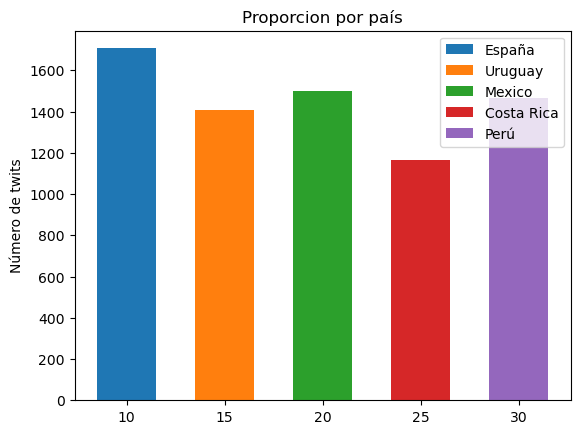

In [842]:
plt.bar(10,Espana_len,3, label="España")
plt.bar(15,Uruguay_len,3, label="Uruguay")
plt.bar(20,Mexico_len,3, label="Mexico")
plt.bar(25,CostaRica_len,3, label="Costa Rica")
plt.bar(30,Peru_len,3, label="Perú")
plt.legend()
plt.ylabel('Número de twits')
plt.title('Proporcion por país')
plt.show()

In [843]:
#PARA MOSTRAR PORCENTAJES EN GRAFICO DE TARTA
#completo.groupby('pais').size()

In [844]:
figura = px.pie(completo, names='pais',
                title='% Tweets por país', 
                width=600, height=500, 
                hole=0.3 ,
                color='pais', 
                color_discrete_sequence=px.colors.sequential.GnBu_r,) 
figura.update_traces(textposition='inside', textinfo='percent+label')
figura.show()


<div class="alert alert-block alert-info"><b>La mayor parte de tweets proceden de España seguido de Perú y México. Costa Rica</b></div>


<a id="1.1.2"></a> 
## 1.1.2 ¿Qué país escribe más en cada tweet?


In [845]:
fig = px.histogram(data_frame =completo, x ="length",color = 'pais', title="¿Qué país escribe más?")
fig.show()

<div class="alert alert-block alert-info"><b>La mayoría de tweets tienen menos de 146 caracteres, sin embargo, cabe destacar un tweet que se realizó en Uruguay con 2592</b></div>


<a id="1.1.3"></a> 
## 1.1.3 ¿Cuáles son las palabras más presentes en los tweets?

In [846]:
completo.texto

0      En definitiva! Me quedé sin campo para ir a Ta...
1      @dianalaa32 Es una escena de uno de los docume...
2      Qué feo es tener que terminar con alguien; y m...
3      Oído en McDonalds "el mejor mannequin challeng...
4      Tengo que aceptar que me esta hundiendo el con...
                             ...                        
459    @sebatramp Acá también, Seba ???? Para peor el...
460    @Phoyu_Agustina no soy hack pero es imposible ...
461    Nadie te vende un The Last of Us Remastered po...
462    Me propuse dejar las redes, las salidas &amp; ...
463    @irenichus siii! Voy como en media hora. Me va...
Name: texto, Length: 7245, dtype: object

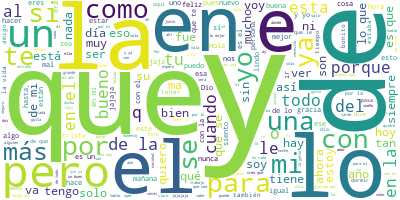

In [847]:
nube_palabras(completo.texto)

<a id="1.1.4"></a> 
## 1.1.4 ¿Cuál es el sentimiento en cada país?

In [848]:
fig = px.histogram(data_frame = completo, x ="tipo",color = 'pais', barmode="group", title="¿Con qué sentimiento se escribe?")
fig.show()

<div class="alert alert-block alert-info"><b>Destaca la neutralidad de los tweets de Perú respecto al resto de países. México y España son los países con sentimiento más negativos mientras que el sentimiento positivo está más repartido entre todos los países</b></div>


<a id="1.1.5"></a> 
## 1.1.5 Hagstags más populares

In [849]:
fig = go.Figure()
fig.add_trace(go.Bar(y=list(top_hastag.keys()), x=list(top_hastag.values()),orientation='h'))

fig.update_layout(title="Hastags más populares",
                      xaxis_title="Número de tweets",
                      yaxis_title='Hastag')

fig.show()

<a id="1.1.6"></a> 
## 1.1.6 Usuarios de twitter más mencionados

In [850]:
fig = go.Figure()
fig.add_trace(go.Bar(y=list(top_mentions.keys()), x=list(top_mentions.values()),orientation='h'))

fig.update_layout(title="Usuarios más populares",
                      xaxis_title="Número de menciones",
                      yaxis_title='Menciones')
fig.show()

<div class="alert alert-block alert-info"><b>El usuario <i> Cuervotinelli </i> es el que más menciones tiene con diferencia.</b></div>


<a id="2"></a>
# 2.Preprocesamiento de datos
[Tabla de contenidos](#0)
<div class="alert alert-block alert-info"> <b></b> Eliminación de caracteres especiales, conversiones de formato, tokenización, eliminación de palabras irrelevantes, etc. </div>


In [851]:
pre_process = completo

In [852]:
pre_process.head(10)

id                                              texto   
0  809927403615256576  En definitiva! Me quedé sin campo para ir a Ta...  \
1  796040775364710400  @dianalaa32 Es una escena de uno de los docume...   
2  802912779854352384  Qué feo es tener que terminar con alguien; y m...   
3  800835505717972992  Oído en McDonalds "el mejor mannequin challeng...   
4  791640101751230464  Tengo que aceptar que me esta hundiendo el con...   
5  758451150349664256  Mmm no quiero hacer spoiler pero hoy va a ver ...   
6  760715780732354561                     @itsdylanjos yo solo las cucas   
7  800388250942709760                 @Adri_hdezv Bby muy duro la verdad   
8  801870717969174529             @_AlejandroDP no estoy en la zona roja   
9  814853214050906112     Quiero como tener carro para hacer todo rápido   

       tipo       pais   data  length     hashtag        mentions  
0  Negative  CostaRica  train     110  [#percebe]              []  
1  Positive  CostaRica  train     134          []   [@dianalaa32]  
2  Negative  CostaRica  train     117          []              []  
3  Negative  CostaRica  train     136          []              []  
4   Neutral  CostaRica  train     132          []              []  
5   Neutral  CostaRica  train     125          []              []  
6   Neutral  CostaRica  train      30          []  [@itsdylanjos]  
7  Negative  CostaRica  train      34          []   [@Adri_hdezv]  
8   Neutral  CostaRica  train      38          []              []  
9   Neutral  CostaRica  train      46          []              []

In [853]:
pre_process['stemmer'] = pre_process.texto

In [854]:
pre_process.head(5)

id                                              texto   
0  809927403615256576  En definitiva! Me quedé sin campo para ir a Ta...  \
1  796040775364710400  @dianalaa32 Es una escena de uno de los docume...   
2  802912779854352384  Qué feo es tener que terminar con alguien; y m...   
3  800835505717972992  Oído en McDonalds "el mejor mannequin challeng...   
4  791640101751230464  Tengo que aceptar que me esta hundiendo el con...   

       tipo       pais   data  length     hashtag       mentions   
0  Negative  CostaRica  train     110  [#percebe]             []  \
1  Positive  CostaRica  train     134          []  [@dianalaa32]   
2  Negative  CostaRica  train     117          []             []   
3  Negative  CostaRica  train     136          []             []   
4   Neutral  CostaRica  train     132          []             []   

                                             stemmer  
0  En definitiva! Me quedé sin campo para ir a Ta...  
1  @dianalaa32 Es una escena de uno de los docume...  
2  Qué feo es tener que terminar con alguien; y m...  
3  Oído en McDonalds "el mejor mannequin challeng...  
4  Tengo que aceptar que me esta hundiendo el con...

In [855]:
#TEXTO DE LOS TWEETS A MINUSCULAS
def remove_special(s):
    s = re.sub(r'[^\w\s]', '', s)

    return s

In [856]:
pre_process["stemmer"] = pre_process["stemmer"].apply(lambda elem: re.sub(r"(@[A-Za-z0–9\_]+)|((http|https)\:\/\/)?[A-Za-z0–9\.\/\?\:@\-_=#]+\.([A-Za-z]){2,6}([A-Za-z0–9\.\&\/\?\:@\-_=#])*","",elem,flags=re.MULTILINE))

In [857]:
#TEXTO DE LOS TWEETS A MINUSCULAS
pre_process['stemmer'] = pre_process.stemmer.str.lower()

In [858]:
pre_process['stemmer'] = pre_process.stemmer.apply(remove_special)

In [859]:
pre_process.head(5)

id                                              texto   
0  809927403615256576  En definitiva! Me quedé sin campo para ir a Ta...  \
1  796040775364710400  @dianalaa32 Es una escena de uno de los docume...   
2  802912779854352384  Qué feo es tener que terminar con alguien; y m...   
3  800835505717972992  Oído en McDonalds "el mejor mannequin challeng...   
4  791640101751230464  Tengo que aceptar que me esta hundiendo el con...   

       tipo       pais   data  length     hashtag       mentions   
0  Negative  CostaRica  train     110  [#percebe]             []  \
1  Positive  CostaRica  train     134          []  [@dianalaa32]   
2  Negative  CostaRica  train     117          []             []   
3  Negative  CostaRica  train     136          []             []   
4   Neutral  CostaRica  train     132          []             []   

                                             stemmer  
0  en definitiva me quedé sin campo para ir a tac...  
1  32 es una escena de uno de los documentales má...  
2  qué feo es tener que terminar con alguien y má...  
3  oído en mcdonalds el mejor mannequin challenge...  
4  tengo que aceptar que me esta hundiendo el con...

In [860]:
#ELIMINACION DE LOS STOPWORDS
stop_words = sws.words('spanish')

In [861]:
np.array(stop_words)
print("Número de stopwords: ", len(stop_words))

Número de stopwords:  313


In [862]:
tk = WhitespaceTokenizer()

In [863]:
pre_process.stemmer = pre_process.stemmer.apply(lambda x: ' '.join([word for word in tk.tokenize(x) if word not in (stop_words)]))

In [864]:
pre_process.sample(5)

id                                              texto   
915  795760136371507204  Pues yo digo que todos aquí son felices, cada ...  \
84   768562234582851584  Por desgracia el sorteo que tenía pensado hace...   
326  755959067454087169  hace tiempo (como un mes o algo así) hable con...   
249  818669480477945857        Una rosa más y estoy a dos de volverme loco   
283  819357553234739200        Por eso les digo que no se ilusionen chavos   

         tipo     pais   data  length hashtag mentions   
915  Negative   Mexico  train     133      []       []  \
84   Negative   España  train     117      []       []   
326   Neutral  Uruguay   test     137      []       []   
249  Negative   Mexico  train      43      []       []   
283  Negative   Mexico   test      43      []       []   

                                               stemmer  
915  pues digo aquí felices cada pregunto dicen bie...  
84   desgracia sorteo pensado hacer sólo gente euro...  
326  hace tiempo mes así hable sehun biased cayó re...  
249                             rosa dos volverme loco  
283                              digo ilusionen chavos

In [865]:
pre_process.stemmer = pre_process.stemmer.str.normalize('NFKD').str.encode('ascii',errors='ignore').str.decode('utf-8')

In [866]:
pre_process.head(2)

id                                              texto   
0  809927403615256576  En definitiva! Me quedé sin campo para ir a Ta...  \
1  796040775364710400  @dianalaa32 Es una escena de uno de los docume...   

       tipo       pais   data  length     hashtag       mentions   
0  Negative  CostaRica  train     110  [#percebe]             []  \
1  Positive  CostaRica  train     134          []  [@dianalaa32]   

                                             stemmer  
0  definitiva quede campo ir tacares mentalizado ...  
1  32 escena documentales respetados naturaleza p...

In [867]:
#ELIMINACION DE CARACTERES ESPECIALES y DIGITOS

In [868]:
pre_process.stemmer = pre_process.stemmer.apply(remove_special)

In [869]:
pre_process.head(2)

id                                              texto   
0  809927403615256576  En definitiva! Me quedé sin campo para ir a Ta...  \
1  796040775364710400  @dianalaa32 Es una escena de uno de los docume...   

       tipo       pais   data  length     hashtag       mentions   
0  Negative  CostaRica  train     110  [#percebe]             []  \
1  Positive  CostaRica  train     134          []  [@dianalaa32]   

                                             stemmer  
0  definitiva quede campo ir tacares mentalizado ...  
1  32 escena documentales respetados naturaleza p...

In [870]:
pre_process.stemmer.replace('\d+', '', regex=True, inplace=True)

In [871]:
pre_process.head(2)

id                                              texto   
0  809927403615256576  En definitiva! Me quedé sin campo para ir a Ta...  \
1  796040775364710400  @dianalaa32 Es una escena de uno de los docume...   

       tipo       pais   data  length     hashtag       mentions   
0  Negative  CostaRica  train     110  [#percebe]             []  \
1  Positive  CostaRica  train     134          []  [@dianalaa32]   

                                             stemmer  
0  definitiva quede campo ir tacares mentalizado ...  
1   escena documentales respetados naturaleza pla...

In [872]:
#FUNCION PARA ELIMINAR CARACTERES REPETIDOS CONSECUTIVOS
def consecutive_characters(str1):
    k = len(str1)
    i=0
   
    while i < k-1:
        if (str1[i] == str1[i+1]) and not str1[i] in(['l','r']):
            str1 = str1[:i] + str1[i + 1:]
            i=i-1
            k = len(str1)
        i = i+1
    return str1.strip()

In [873]:
pre_process.head(5)

id                                              texto   
0  809927403615256576  En definitiva! Me quedé sin campo para ir a Ta...  \
1  796040775364710400  @dianalaa32 Es una escena de uno de los docume...   
2  802912779854352384  Qué feo es tener que terminar con alguien; y m...   
3  800835505717972992  Oído en McDonalds "el mejor mannequin challeng...   
4  791640101751230464  Tengo que aceptar que me esta hundiendo el con...   

       tipo       pais   data  length     hashtag       mentions   
0  Negative  CostaRica  train     110  [#percebe]             []  \
1  Positive  CostaRica  train     134          []  [@dianalaa32]   
2  Negative  CostaRica  train     117          []             []   
3  Negative  CostaRica  train     136          []             []   
4   Neutral  CostaRica  train     132          []             []   

                                             stemmer  
0  definitiva quede campo ir tacares mentalizado ...  
1   escena documentales respetados naturaleza pla...  
2  feo tener terminar alguien dos personas aun am...  
3  oido mcdonalds mejor mannequin challenge visto...  
4  aceptar hundiendo consumismo nueva macbook pro...

In [874]:
pre_process.stemmer = pre_process.stemmer.apply(consecutive_characters)

In [875]:
pre_process.head(20)

id                                              texto   
0   809927403615256576  En definitiva! Me quedé sin campo para ir a Ta...  \
1   796040775364710400  @dianalaa32 Es una escena de uno de los docume...   
2   802912779854352384  Qué feo es tener que terminar con alguien; y m...   
3   800835505717972992  Oído en McDonalds "el mejor mannequin challeng...   
4   791640101751230464  Tengo que aceptar que me esta hundiendo el con...   
5   758451150349664256  Mmm no quiero hacer spoiler pero hoy va a ver ...   
6   760715780732354561                     @itsdylanjos yo solo las cucas   
7   800388250942709760                 @Adri_hdezv Bby muy duro la verdad   
8   801870717969174529             @_AlejandroDP no estoy en la zona roja   
9   814853214050906112     Quiero como tener carro para hacer todo rápido   
10  815439552038977537         Tristeza más hp me da siempre en año nuevo   
11  817032173689696257  @sancarlena77 @miguelpintor05 @demalaspalabras...   
12  811219074059476992  @eebenitez_ Jajaja es muy triste esto, pero ya...   
13  813467340713193472  @ignaciosolisw ya yo voy de vuelta, pero le de...   
14  814710034236080128  @BrujaMalvada_ no tengo en la casa apenas entr...   
15  808870364856090625  mañana tengo el día libre y no tengo nada más ...   
16  815388797747666944  @Jovel_Alvarez no sé si a todos les funcione p...   
17  811086379199397889  Para mi mamá toda la ropa que escojo es fea ha...   
18  801958572213108737  @vesamo13 ok, vea el lado positivo, tiene un m...   
19  802227237000978432  En mi pueblo anda una patrulla de @fuerzapubli...   

        tipo       pais   data  length            hashtag   
0   Negative  CostaRica  train     110         [#percebe]  \
1   Positive  CostaRica  train     134                 []   
2   Negative  CostaRica  train     117                 []   
3   Negative  CostaRica  train     136                 []   
4    Neutral  CostaRica  train     132                 []   
5    Neutral  CostaRica  train     125                 []   
6    Neutral  CostaRica  train      30                 []   
7   Negative  CostaRica  train      34                 []   
8    Neutral  CostaRica  train      38                 []   
9    Neutral  CostaRica  train      46                 []   
10  Negative  CostaRica  train      42                 []   
11   Neutral  CostaRica  train      83                 []   
12  Positive  CostaRica  train      63                 []   
13  Positive  CostaRica  train      67                 []   
14   Neutral  CostaRica  train      70                 []   
15  Positive  CostaRica  train      66                 []   
16  Positive  CostaRica  train      85                 []   
17   Neutral  CostaRica  train      69                 []   
18  Positive  CostaRica  train      91                 []   
19  Positive  CostaRica  train     127  [#CostaRicaUnida]   

                                             mentions   
0                                                  []  \
1                                       [@dianalaa32]   
2                                                  []   
3                                                  []   
4                                                  []   
5                                                  []   
6                                      [@itsdylanjos]   
7                                       [@Adri_hdezv]   
8                                                  []   
9                                                  []   
10                                                 []   
11  [@sancarlena77, @miguelpintor05, @demalaspalab...   
12                                      [@eebenitez_]   
13                                   [@ignaciosolisw]   
14                                   [@BrujaMalvada_]   
15                                                 []   
16                                   [@Jovel_Alvarez]   
17                                                 []   
18                                   

In [876]:
#REEMPLAZO DE GUIONES BAJOS
pre_process.stemmer.replace('_', ' ', regex =True,inplace=True)

In [877]:
pre_process.head(20)

id                                              texto   
0   809927403615256576  En definitiva! Me quedé sin campo para ir a Ta...  \
1   796040775364710400  @dianalaa32 Es una escena de uno de los docume...   
2   802912779854352384  Qué feo es tener que terminar con alguien; y m...   
3   800835505717972992  Oído en McDonalds "el mejor mannequin challeng...   
4   791640101751230464  Tengo que aceptar que me esta hundiendo el con...   
5   758451150349664256  Mmm no quiero hacer spoiler pero hoy va a ver ...   
6   760715780732354561                     @itsdylanjos yo solo las cucas   
7   800388250942709760                 @Adri_hdezv Bby muy duro la verdad   
8   801870717969174529             @_AlejandroDP no estoy en la zona roja   
9   814853214050906112     Quiero como tener carro para hacer todo rápido   
10  815439552038977537         Tristeza más hp me da siempre en año nuevo   
11  817032173689696257  @sancarlena77 @miguelpintor05 @demalaspalabras...   
12  811219074059476992  @eebenitez_ Jajaja es muy triste esto, pero ya...   
13  813467340713193472  @ignaciosolisw ya yo voy de vuelta, pero le de...   
14  814710034236080128  @BrujaMalvada_ no tengo en la casa apenas entr...   
15  808870364856090625  mañana tengo el día libre y no tengo nada más ...   
16  815388797747666944  @Jovel_Alvarez no sé si a todos les funcione p...   
17  811086379199397889  Para mi mamá toda la ropa que escojo es fea ha...   
18  801958572213108737  @vesamo13 ok, vea el lado positivo, tiene un m...   
19  802227237000978432  En mi pueblo anda una patrulla de @fuerzapubli...   

        tipo       pais   data  length            hashtag   
0   Negative  CostaRica  train     110         [#percebe]  \
1   Positive  CostaRica  train     134                 []   
2   Negative  CostaRica  train     117                 []   
3   Negative  CostaRica  train     136                 []   
4    Neutral  CostaRica  train     132                 []   
5    Neutral  CostaRica  train     125                 []   
6    Neutral  CostaRica  train      30                 []   
7   Negative  CostaRica  train      34                 []   
8    Neutral  CostaRica  train      38                 []   
9    Neutral  CostaRica  train      46                 []   
10  Negative  CostaRica  train      42                 []   
11   Neutral  CostaRica  train      83                 []   
12  Positive  CostaRica  train      63                 []   
13  Positive  CostaRica  train      67                 []   
14   Neutral  CostaRica  train      70                 []   
15  Positive  CostaRica  train      66                 []   
16  Positive  CostaRica  train      85                 []   
17   Neutral  CostaRica  train      69                 []   
18  Positive  CostaRica  train      91                 []   
19  Positive  CostaRica  train     127  [#CostaRicaUnida]   

                                             mentions   
0                                                  []  \
1                                       [@dianalaa32]   
2                                                  []   
3                                                  []   
4                                                  []   
5                                                  []   
6                                      [@itsdylanjos]   
7                                       [@Adri_hdezv]   
8                                                  []   
9                                                  []   
10                                                 []   
11  [@sancarlena77, @miguelpintor05, @demalaspalab...   
12                                      [@eebenitez_]   
13                                   [@ignaciosolisw]   
14                                   [@BrujaMalvada_]   
15                                                 []   
16                                   [@Jovel_Alvarez]   
17                                                 []   
18                                   

In [878]:
#ELIMINACION DE PALABRAS CON UN UNICO CARACTER y PALABRAS SIN VOCALES
def remove_single_world_character(s):
    l = s.split()
    for x in l:
        if len(x) <2:
            s = s.replace(x,'')
        count = len([char for char in x if char in "aeiou"])
        if count < 1:
            s = s.replace(x,'')
    return s.strip()


In [879]:
pre_process.stemmer = pre_process.stemmer.apply(remove_single_world_character)

In [880]:
pre_process.head(20)

id                                              texto   
0   809927403615256576  En definitiva! Me quedé sin campo para ir a Ta...  \
1   796040775364710400  @dianalaa32 Es una escena de uno de los docume...   
2   802912779854352384  Qué feo es tener que terminar con alguien; y m...   
3   800835505717972992  Oído en McDonalds "el mejor mannequin challeng...   
4   791640101751230464  Tengo que aceptar que me esta hundiendo el con...   
5   758451150349664256  Mmm no quiero hacer spoiler pero hoy va a ver ...   
6   760715780732354561                     @itsdylanjos yo solo las cucas   
7   800388250942709760                 @Adri_hdezv Bby muy duro la verdad   
8   801870717969174529             @_AlejandroDP no estoy en la zona roja   
9   814853214050906112     Quiero como tener carro para hacer todo rápido   
10  815439552038977537         Tristeza más hp me da siempre en año nuevo   
11  817032173689696257  @sancarlena77 @miguelpintor05 @demalaspalabras...   
12  811219074059476992  @eebenitez_ Jajaja es muy triste esto, pero ya...   
13  813467340713193472  @ignaciosolisw ya yo voy de vuelta, pero le de...   
14  814710034236080128  @BrujaMalvada_ no tengo en la casa apenas entr...   
15  808870364856090625  mañana tengo el día libre y no tengo nada más ...   
16  815388797747666944  @Jovel_Alvarez no sé si a todos les funcione p...   
17  811086379199397889  Para mi mamá toda la ropa que escojo es fea ha...   
18  801958572213108737  @vesamo13 ok, vea el lado positivo, tiene un m...   
19  802227237000978432  En mi pueblo anda una patrulla de @fuerzapubli...   

        tipo       pais   data  length            hashtag   
0   Negative  CostaRica  train     110         [#percebe]  \
1   Positive  CostaRica  train     134                 []   
2   Negative  CostaRica  train     117                 []   
3   Negative  CostaRica  train     136                 []   
4    Neutral  CostaRica  train     132                 []   
5    Neutral  CostaRica  train     125                 []   
6    Neutral  CostaRica  train      30                 []   
7   Negative  CostaRica  train      34                 []   
8    Neutral  CostaRica  train      38                 []   
9    Neutral  CostaRica  train      46                 []   
10  Negative  CostaRica  train      42                 []   
11   Neutral  CostaRica  train      83                 []   
12  Positive  CostaRica  train      63                 []   
13  Positive  CostaRica  train      67                 []   
14   Neutral  CostaRica  train      70                 []   
15  Positive  CostaRica  train      66                 []   
16  Positive  CostaRica  train      85                 []   
17   Neutral  CostaRica  train      69                 []   
18  Positive  CostaRica  train      91                 []   
19  Positive  CostaRica  train     127  [#CostaRicaUnida]   

                                             mentions   
0                                                  []  \
1                                       [@dianalaa32]   
2                                                  []   
3                                                  []   
4                                                  []   
5                                                  []   
6                                      [@itsdylanjos]   
7                                       [@Adri_hdezv]   
8                                                  []   
9                                                  []   
10                                                 []   
11  [@sancarlena77, @miguelpintor05, @demalaspalab...   
12                                      [@eebenitez_]   
13                                   [@ignaciosolisw]   
14                                   [@BrujaMalvada_]   
15                                                 []   
16                                   [@Jovel_Alvarez]   
17                                                 []   
18                                   

In [881]:
procesado = pre_process

In [882]:
procesado.head(20)

id                                              texto   
0   809927403615256576  En definitiva! Me quedé sin campo para ir a Ta...  \
1   796040775364710400  @dianalaa32 Es una escena de uno de los docume...   
2   802912779854352384  Qué feo es tener que terminar con alguien; y m...   
3   800835505717972992  Oído en McDonalds "el mejor mannequin challeng...   
4   791640101751230464  Tengo que aceptar que me esta hundiendo el con...   
5   758451150349664256  Mmm no quiero hacer spoiler pero hoy va a ver ...   
6   760715780732354561                     @itsdylanjos yo solo las cucas   
7   800388250942709760                 @Adri_hdezv Bby muy duro la verdad   
8   801870717969174529             @_AlejandroDP no estoy en la zona roja   
9   814853214050906112     Quiero como tener carro para hacer todo rápido   
10  815439552038977537         Tristeza más hp me da siempre en año nuevo   
11  817032173689696257  @sancarlena77 @miguelpintor05 @demalaspalabras...   
12  811219074059476992  @eebenitez_ Jajaja es muy triste esto, pero ya...   
13  813467340713193472  @ignaciosolisw ya yo voy de vuelta, pero le de...   
14  814710034236080128  @BrujaMalvada_ no tengo en la casa apenas entr...   
15  808870364856090625  mañana tengo el día libre y no tengo nada más ...   
16  815388797747666944  @Jovel_Alvarez no sé si a todos les funcione p...   
17  811086379199397889  Para mi mamá toda la ropa que escojo es fea ha...   
18  801958572213108737  @vesamo13 ok, vea el lado positivo, tiene un m...   
19  802227237000978432  En mi pueblo anda una patrulla de @fuerzapubli...   

        tipo       pais   data  length            hashtag   
0   Negative  CostaRica  train     110         [#percebe]  \
1   Positive  CostaRica  train     134                 []   
2   Negative  CostaRica  train     117                 []   
3   Negative  CostaRica  train     136                 []   
4    Neutral  CostaRica  train     132                 []   
5    Neutral  CostaRica  train     125                 []   
6    Neutral  CostaRica  train      30                 []   
7   Negative  CostaRica  train      34                 []   
8    Neutral  CostaRica  train      38                 []   
9    Neutral  CostaRica  train      46                 []   
10  Negative  CostaRica  train      42                 []   
11   Neutral  CostaRica  train      83                 []   
12  Positive  CostaRica  train      63                 []   
13  Positive  CostaRica  train      67                 []   
14   Neutral  CostaRica  train      70                 []   
15  Positive  CostaRica  train      66                 []   
16  Positive  CostaRica  train      85                 []   
17   Neutral  CostaRica  train      69                 []   
18  Positive  CostaRica  train      91                 []   
19  Positive  CostaRica  train     127  [#CostaRicaUnida]   

                                             mentions   
0                                                  []  \
1                                       [@dianalaa32]   
2                                                  []   
3                                                  []   
4                                                  []   
5                                                  []   
6                                      [@itsdylanjos]   
7                                       [@Adri_hdezv]   
8                                                  []   
9                                                  []   
10                                                 []   
11  [@sancarlena77, @miguelpintor05, @demalaspalab...   
12                                      [@eebenitez_]   
13                                   [@ignaciosolisw]   
14                                   [@BrujaMalvada_]   
15                                                 []   
16                                   [@Jovel_Alvarez]   
17                                                 []   
18                                   

In [883]:
procesado['lemmatizer'] = procesado['stemmer']

In [884]:
#!python -m spacy download es_core_news_md

In [885]:
import spacy
nlp = spacy.load("es_core_news_md")

In [886]:
procesado["spacy"]  = procesado['stemmer'].apply(lambda x: " ".join([y.lemma_ for y in nlp(x)]))

In [887]:
procesado

id                                              texto   
0    809927403615256576  En definitiva! Me quedé sin campo para ir a Ta...  \
1    796040775364710400  @dianalaa32 Es una escena de uno de los docume...   
2    802912779854352384  Qué feo es tener que terminar con alguien; y m...   
3    800835505717972992  Oído en McDonalds "el mejor mannequin challeng...   
4    791640101751230464  Tengo que aceptar que me esta hundiendo el con...   
..                  ...                                                ...   
459  801994750089904128  @sebatramp Acá también, Seba ???? Para peor el...   
460  801561284420521989  @Phoyu_Agustina no soy hack pero es imposible ...   
461  805712525727645696  Nadie te vende un The Last of Us Remastered po...   
462  796172973967310848  Me propuse dejar las redes, las salidas &amp; ...   
463  811595209029124096  @irenichus siii! Voy como en media hora. Me va...   

         tipo       pais   data  length         hashtag           mentions   
0    Negative  CostaRica  train     110      [#percebe]                 []  \
1    Positive  CostaRica  train     134              []      [@dianalaa32]   
2    Negative  CostaRica  train     117              []                 []   
3    Negative  CostaRica  train     136              []                 []   
4     Neutral  CostaRica  train     132              []                 []   
..        ...        ...    ...     ...             ...                ...   
459  Negative    Uruguay   test      88              []       [@sebatramp]   
460   Neutral    Uruguay   test      90              []  [@Phoyu_Agustina]   
461  Negative    Uruguay   test      90              []                 []   
462   Neutral    Uruguay   test     105              []                 []   
463  Positive    Uruguay   test     117  [#foreverpink]       [@irenichus]   

                                               stemmer   
0    definitiva quede campo ir tacares mentalizado ...  \
1    escena documentales respetados naturaleza plan...   
2    feo tener terminar alguien dos personas aun am...   
3    oido mcdonalds mejor manequin challenge visto ...   
4    aceptar hundiendo consumismo nueva macbok pro ...   
..                                                 ...   
459      aca seba peor sismografo da datos tiempo real   
460          hack imposible sacarme ac  gano confianza   
461  nadie vende the last of us remastered menos do...   
462  propuse dejar redes salidas amp estudiar histo...   
463  si voy media hora vas reconocer musculosa hava...   

                                            lemmatizer   
0    definitiva quede campo ir tacares mentalizado ...  \
1    escena documentales respetados naturaleza plan...   
2    feo tener terminar alguien dos personas aun am...   
3    oido mcdonalds mejor manequin challenge visto ...   
4    aceptar hundiendo consumismo nueva macbok pro ...   
..                                                 ...   
459      aca seba peor sismografo da datos tiempo real   
460          hack imposible sacarme ac  gano confianza   
461  nadie vende the last of us remastered menos do...   
462  propuse dejar redes salidas amp estudiar histo...   
463  si voy media hora vas reconocer musculosa hava...   

                                                 spacy  
0    definitivo quedar campo ir tacar mentalizado q...  
1    escena documental respetado naturaleza planet ...  
2    feo tener terminar alguien dos persona aun ama...  
3    oido mcdonalds mejor manequin challenge visto ...  
4    aceptar hundir consumismo nuevo macbok pro gop...  
..                                                 ...  
459      aca seba peor sismografo dar dato tiempo real  
460        hack imposible sacar yo ac   gano confianza  
461  nadie vender the last of us remastered menos d...  
462  propusar dejar red salida amp estudiar histori...  
463  si ir medio hora ir reconocer musculós havaian...  

[7245 rows x 11 columns]

In [888]:
procesado.sample(2)

id                                              texto   
738  769610090345275392  @carlosmchef3 felicidades pareja!!! Peazo abue...  \
219  804672475485315073  Cada dia se acerca mas la navidad agamos que t...   

         tipo    pais   data  length hashtag         mentions   
738  Positive  España  train      88      []  [@carlosmchef3]  \
219   Neutral    Peru   test     129      []               []   

                                               stemmer   
738      feliciddes prej pezo buelo v tener  pletorico  \
219  cada dia acerca mas navidad agamos ninos motiv...   

                                            lemmatizer   
738      feliciddes prej pezo buelo v tener  pletorico  \
219  cada dia acerca mas navidad agamos ninos motiv...   

                                                 spacy  
738       felicidd prej pezo buelo v tener   pletorico  
219  cada dia acerca mas navidad acer nino motivo  ...

In [889]:
def nube_palabras(palabras_lista):
    long_string = ''.join(str(x) for x in palabras_lista)
    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=10, contour_width=3, contour_color='steelblue')
    # Generate a word cloud
    wordcloud.generate(long_string)
    # Visualize the word cloud
    return wordcloud.to_image()
    

In [890]:
from nltk import word_tokenize
stemmer = SnowballStemmer('spanish')
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\evill\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [891]:
procesado['stemmer'] = procesado['stemmer'].apply(lambda x: [stemmer.stem(x) for x in word_tokenize(x)])

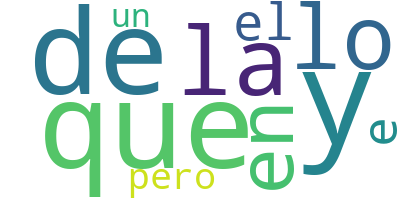

In [892]:
nube_palabras(procesado.texto)

<div class="alert alert-block alert-info"><b>Texto inicial</b></div>

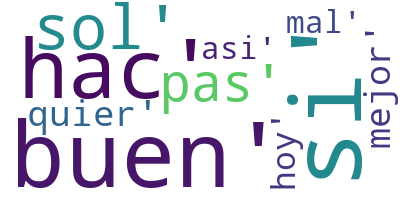

In [893]:
nube_palabras(procesado.stemmer)

<div class="alert alert-block alert-info"><b>Texto procesado técnica stemmer</b></div>

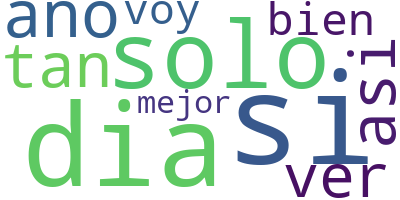

In [894]:
nube_palabras(procesado.lemmatizer)

<div class="alert alert-block alert-info"><b>Texto procesado técnica lematización (librería Stanza)</b></div>

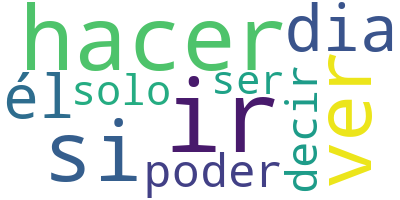

In [895]:
nube_palabras(procesado.spacy)

<div class="alert alert-block alert-info"><b>Texto procesado técnica lematización (librería Spacy)</b></div>

<a id="3"></a>
# 3.Técnicas de clustering
[Tabla de contenidos](#0)
<div class="alert alert-block alert-info"> <b></b> Implementación de cinco técnicas de clustering</div>


<div class="alert alert-block alert-success"> <b>STEMMING:</b>Cuando queremos buscar una palabra en documentos, tal vez nos interese utilizar este método para recuperar más documentos relacionados con
la palabra. Por ejemplo si buscamos ”biblioteca” a secas, nos devolverá los
documentos que contengan esta palabra. pero si aplicamos stemming, la
raíz seria ”bibliotec” y nos devolvería documentos que contengan además de
”biblioteca” los que tienen ”bibliotecario”.</div>

<div class="alert alert-block alert-success"> <b>LEMATIZACIÓN: </b>La lematización es un proceso lingüístico que consiste en, dada una forma
flexionada (es decir, en plural, en femenino, conjugada, etc), hallar el lema
correspondiente. El lema es la forma que por convenio se acepta como representante de todas las formas flexionadas de una palabra.
Por ejemplo : ”dije”,”decían”,”diré” tienen como lema la palabra ”decir”</div>

<div class="alert alert-block alert-success"> <b>CORPUS: </b> se representa
en una matriz cuyas filas contiene todos los términos distintos del corpus
(palabras) y las columnas representen una ventana contextual en la que
aparecen esos términos</div>

<a id="3.1"></a> 
## 3.1. HDP Hierrarchical Dirichlet Process(HDP) (técnica de stemmización)
[Tabla de contenidos](#0)

<div class="alert alert-block alert-success"> <b>HDP: </b>cada grupo es un tweet que consta de una bolsa de palabras, cada grupo es un tema y cada tweet es una mezcla de temas.</div>

In [896]:
from gensim.models import HdpModel
from gensim.models import CoherenceModel
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

In [939]:
procesado.head(2)

id                                              texto   
0  809927403615256576  En definitiva! Me quedé sin campo para ir a Ta...  \
1  796040775364710400  @dianalaa32 Es una escena de uno de los docume...   

       tipo       pais   data  length     hashtag       mentions   
0  Negative  CostaRica  train     110  [#percebe]             []  \
1  Positive  CostaRica  train     134          []  [@dianalaa32]   

                                             stemmer   
0  [definit, qued, camp, ir, tacar, mentaliz, que...  \
1  [escen, documental, respet, naturalez, planet,...   

                                          lemmatizer   
0  definitiva quede campo ir tacares mentalizado ...  \
1  escena documentales respetados naturaleza plan...   

                                               spacy  
0  definitivo quedar campo ir tacar mentalizado q...  
1  escena documental respetado naturaleza planet ...

In [899]:
precorpus = procesado.stemmer.tolist()

In [923]:
precorpus

[['definit',
  'qued',
  'camp',
  'ir',
  'tacar',
  'mentaliz',
  'queri',
  'ir',
  'perceb'],
 ['escen',
  'documental',
  'respet',
  'naturalez',
  'planet',
  'earth',
  'dud',
  'mont'],
 ['feo',
  'ten',
  'termin',
  'algui',
  'dos',
  'person',
  'aun',
  'aman',
  'entorn',
  'favor'],
 ['oid',
  'mcdonalds',
  'mejor',
  'manequin',
  'challeng',
  'vist',
  'ahor',
  'ven',
  'hac',
  'gobiern',
  'hac',
  'dos',
  'anos'],
 ['acept',
  'hund',
  'consum',
  'nuev',
  'macbok',
  'pro',
  'gopr',
  'her',
  'gopr',
  'karm',
  'nintend',
  'switch'],
 ['quier',
  'hac',
  'spoil',
  'hoy',
  'va',
  'ver',
  'nuev',
  'canall',
  'podr',
  'ver',
  'nuev',
  'vide',
  'subir',
  'unas',
  'hor'],
 ['sol', 'cuc'],
 ['dur', 'verd'],
 ['zon', 'roj'],
 ['quier', 'ten', 'carr', 'hac', 'rap'],
 ['tristez', 'da', 'siempr', 'ano', 'nuev'],
 ['sip', 'entendi', 'tuit', 'anterior'],
 ['jajaj', 'trist', 'hoy', 'consig'],
 ['voy', 'vuelt', 'dej', 'pamp', 'lindisim'],
 ['cas', 'apen',

In [900]:
dictionary = Dictionary(precorpus)

In [901]:
dictionary.compactify()

In [902]:
dictionary.filter_extremes(no_below=2, no_above=0.97, keep_n=None)

In [903]:
dictionary.compactify()

In [904]:
print(dictionary)

Dictionary<3860 unique tokens: ['camp', 'definit', 'ir', 'qued', 'queri']...>


In [905]:
corpus = [dictionary.doc2bow(text) for text in procesado['stemmer']]

In [906]:
hdp = HdpModel(corpus=corpus, id2word=dictionary)

In [907]:
hdp.print_topics(num_topics=8, num_words=20)

[(0,
  '0.002*numer + 0.002*imbecil + 0.002*caen + 0.002*deficit + 0.002*send + 0.002*cuzc + 0.002*podri + 0.002*except + 0.002*influenci + 0.002*apuest + 0.001*organiz + 0.001*inspiracion + 0.001*asimetr + 0.001*loc + 0.001*zum + 0.001*to + 0.001*sabor + 0.001*tercer + 0.001*vos + 0.001*guadalup'),
 (1,
  '0.002*foc + 0.002*si + 0.002*cent + 0.002*vert + 0.002*profesional + 0.002*practic + 0.002*contagi + 0.001*prefier + 0.001*cualqu + 0.001*ser + 0.001*estupidez + 0.001*gran + 0.001*mism + 0.001*amer + 0.001*premier + 0.001*ex + 0.001*lun + 0.001*got + 0.001*laur + 0.001*present'),
 (2,
  '0.002*toled + 0.002*sofoc + 0.002*chever + 0.002*can + 0.002*resuelt + 0.002*port + 0.002*vea + 0.002*amaneci + 0.002*encontrart + 0.002*tam + 0.002*ajajajajaj + 0.002*motor + 0.002*eleg + 0.002*nadam + 0.001*cerd + 0.001*delant + 0.001*descarg + 0.001*limen + 0.001*conductor + 0.001*sum'),
 (3,
  '0.002*er + 0.002*mio + 0.002*postal + 0.002*bolet + 0.002*evit + 0.002*insoport + 0.002*ridicul + 0.0

In [908]:
CoherenceModel(model=hdp, texts=precorpus, dictionary=dictionary, coherence='c_v').get_coherence()

0.7525693415584812

In [909]:
hdp_topics = hdp.show_topics(num_topics=8, formatted=False)

In [910]:
def nube_topics(model):
    
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
    cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

    topics = model # lda_model.show_topics(formatted=False)
    fig, axes = plt.subplots(2, 2, figsize=(7,7), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')


    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

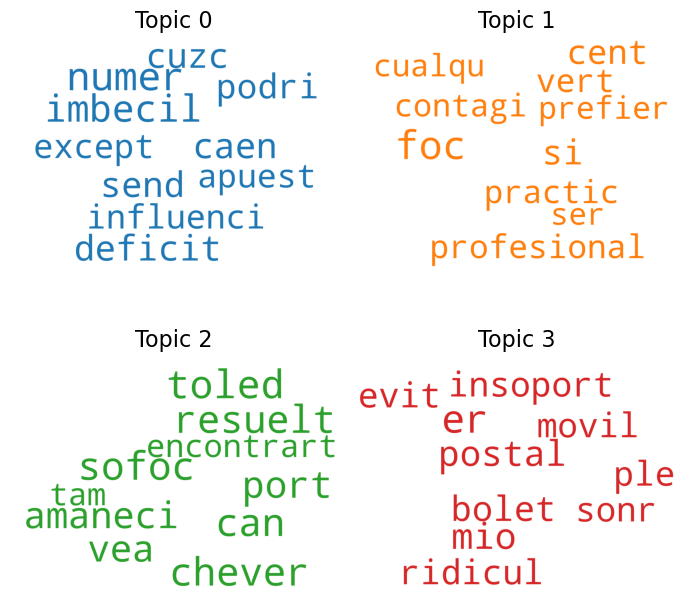

In [911]:
nube_topics(hdp.show_topics(formatted=False))

<div class="alert alert-block alert-info"> <b>Coherencia HDP ténica stemmer:  0.752</b></div>

In [913]:
resultados = {}
resultados['HDP stemmer'] =  0.752

<a id="3.2"></a> 
## 3.2. HDP Hierrarchical Dirichlet Process(HDP) (técnica de lemmatización Stanza)
[Tabla de contenidos](#0)

In [90]:
stanza.download('es')
nlp = stanza.Pipeline('es')

2023-05-30 17:26:44 INFO: Downloading default packages for language: es (Spanish) ...
2023-05-30 17:26:46 INFO: File exists: C:\Users\evill\stanza_resources\es\default.zip
2023-05-30 17:26:52 INFO: Finished downloading models and saved to C:\Users\evill\stanza_resources.
2023-05-30 17:26:52 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-05-30 17:26:54 INFO: Loading these models for language: es (Spanish):
| Processor    | Package  |
---------------------------
| tokenize     | ancora   |
| mwt          | ancora   |
| pos          | ancora   |
| lemma        | ancora   |
| constituency | combined |
| depparse     | ancora   |
| sentiment    | tass2020 |
| ner          | conll02  |

2023-05-30 17:26:54 INFO: Using device: cpu
2023-05-30 17:26:54 INFO: Loading: tokenize
2023-05-30 17:26:54 INFO: Loading: mwt
2023-05-30 17:26:54 INFO: Loading: pos
2023-05-30 17:26:55 INFO: Loading: lemma
2023-05-30 17:26:55 INFO: Loading: constituency
2023-05-30 17:26:55 INFO: Loading: depparse
2023-05-30 17:26:56 INFO: Loading: sentiment
2023-05-30 17:26:56 INFO: Loading: ner
2023-05-30 17:26:57 INFO: Done loading processors!


In [95]:
pre_process.shape

(7245, 10)

In [96]:
def lematizacion(tweet):
    doc = nlp(tweet)
    listado = []
    for sent in doc.sentences:
        for word in sent.words:
            listado.append(word.lemma)
    print(listado)
    return listado

In [97]:
pre_process.lemmatizer = pre_process.lemmatizer.apply(lematizacion)

['definitivo', 'quedar', 'campo', 'ir', 'tacar', 'mentalizado', 'querer', 'ir', 'percebe']
['escena', 'documental', 'respetado', 'naturaleza', 'planet', 'earth', 'dudo', 'montar']
['feo', 'tener', 'terminar', 'alguien', 'dos', 'persona', 'aun', 'amar', 'entorno', 'favorable']
['oido', 'mcdonald', 'mejor', 'manequin', 'challenge', 'visto', 'ahora', 'venir', 'hacer', 'gobierno', 'hacer', 'dos', 'ano']
['aceptar', 'hundir', 'consumismo', 'nuevo', 'macbok', 'pro', 'gopro', 'hero', 'gopro', 'karma', 'nintendo', 'switch']
['querer', 'hacer', 'spoiler', 'hoy', 'ir', 'ver', 'nuevo', 'canallo', 'poder', 'ver', 'nuevo', 'video', 'subir', 'uno', 'hora']
['solo', 'cuca']
['duro', 'verdad']
['zona', 'rojo']
['querer', 'tener', 'carro', 'hacer', 'rapido']
['tristeza', 'dar', 'siempre', 'ano', 'nuevo']
['sip', 'entender', 'tuit', 'anterior']
['jajaja', 'triste', 'hoy', 'él']
['ir', 'vuelta', 'dejar', 'pampa', 'lindisimo']
['casa', 'apenas', 'mando', 'asi', 'jaja']
['manana', 'dia', 'libre', 'hacer', 

In [98]:
pre_process.to_csv('pre_process.csv')

In [99]:
copiaslemeticacion=pre_process

In [100]:
copias2=pre_process

In [117]:
listado = pre_process.lemmatizer.to_list()

In [914]:
procesado = pre_process.copy()

In [106]:
precorpus_lem = procesado.lemmatizer.tolist()

In [108]:
dictionary_lem = Dictionary(precorpus_lem)

In [109]:
dictionary_lem.compactify()

In [110]:
dictionary_lem.filter_extremes(no_below=2, no_above=0.97, keep_n=None)

In [111]:
dictionary_lem.compactify()

In [112]:
corpus_lem = [dictionary_lem.doc2bow(text) for text in procesado['lemmatizer']]

In [113]:
hdp_lem = HdpModel(corpus=corpus_lem, id2word=dictionary_lem)

In [114]:
hdp_lem.print_topics(num_topics=8, num_words=20)

[(0,
  '0.003*apellido + 0.002*instante + 0.002*sur + 0.002*ginebra + 0.002*carinoso + 0.002*burro + 0.001*espalda + 0.001*carbohidrato + 0.001*urgir + 0.001*escritora + 0.001*sincero + 0.001*debi + 0.001*wow + 0.001*llamada + 0.001*tyler + 0.001*gritar + 0.001*penarol + 0.001*tan + 0.001*atascado + 0.001*ana'),
 (1,
  '0.003*solo + 0.002*jajajajajar + 0.002*mina + 0.002*hacer + 0.002*grande + 0.002*ahi + 0.002*comunidad + 0.002*portada + 0.002*frelancer + 0.001*caer + 0.001*costa + 0.001*creer + 0.001*cerebro + 0.001*argumento + 0.001*cena + 0.001*asumir + 0.001*futuro + 0.001*presentacion + 0.001*bajon + 0.001*nunca'),
 (2,
  '0.002*insufrible + 0.002*suficiente + 0.002*navideno + 0.002*campeonato + 0.002*desorden + 0.002*cobarde + 0.002*captar + 0.002*emotivo + 0.002*mona + 0.001*arder + 0.001*enamoro + 0.001*fiesta + 0.001*irme + 0.001*re + 0.001*lider + 0.001*incluir + 0.001*guay + 0.001*hipocrita + 0.001*masaje + 0.001*aqui'),
 (3,
  '0.002*dar + 0.002*sevilla + 0.002*amigo + 0.0

In [115]:
CoherenceModel(model=hdp, texts=precorpus_lem, dictionary=dictionary_lem, coherence='c_v').get_coherence()

0.7558623318112798

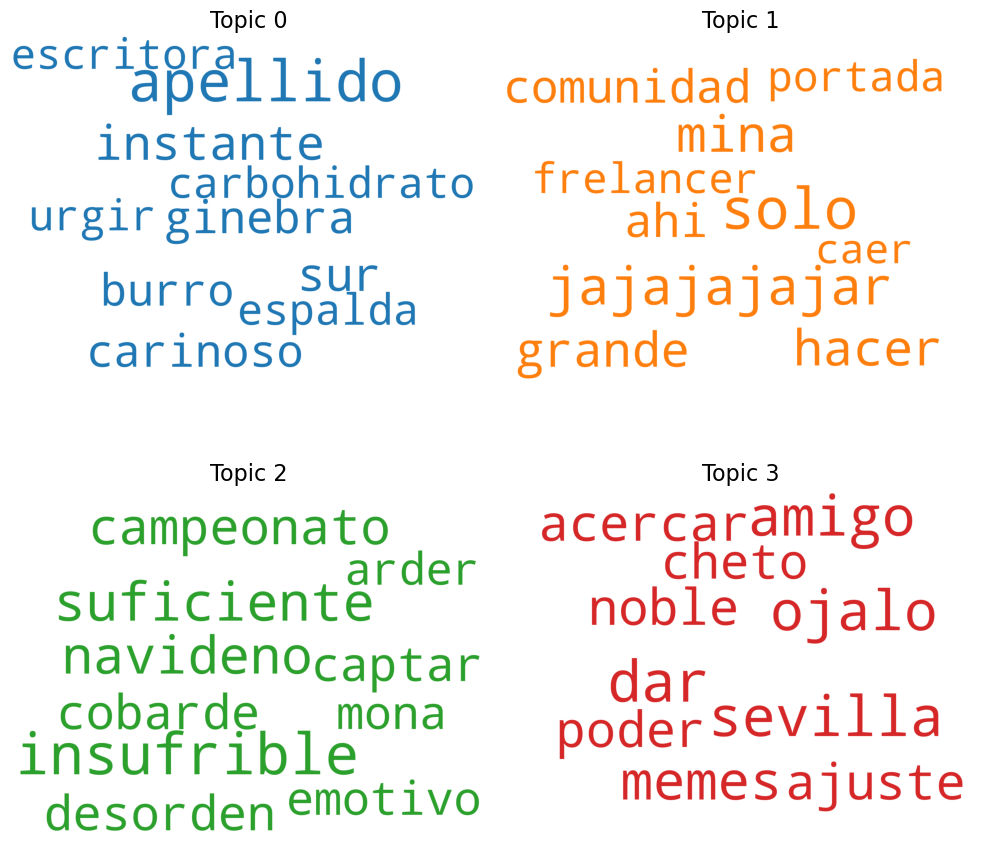

In [116]:
nube_topics(hdp_lem.show_topics(formatted=False))

<div class="alert alert-block alert-info"> <b>Coherencia HDP ténica lemmatizer:  0.75</b></div>

In [ ]:
resultados['HDP stanza']= 0.756

<a id="3.3"></a> 
## 3.2. HDP Hierrarchical Dirichlet Process(HDP) (técnica de lemmatización Spacy)
[Tabla de contenidos](#0)

In [925]:
precorpus_spacy = procesado.spacy.to_list()

In [930]:
def convert_list(tweet):
    return list(tweet.split())

In [931]:
precorpus_spacy = procesado.spacy.apply(lambda x: convert_list(x))

In [932]:
precorpus_spacy

0      [definitivo, quedar, campo, ir, tacar, mentali...
1      [escena, documental, respetado, naturaleza, pl...
2      [feo, tener, terminar, alguien, dos, persona, ...
3      [oido, mcdonalds, mejor, manequin, challenge, ...
4      [aceptar, hundir, consumismo, nuevo, macbok, p...
                             ...                        
459    [aca, seba, peor, sismografo, dar, dato, tiemp...
460    [hack, imposible, sacar, yo, ac, gano, confianza]
461    [nadie, vender, the, last, of, us, remastered,...
462    [propusar, dejar, red, salida, amp, estudiar, ...
463    [si, ir, medio, hora, ir, reconocer, musculós,...
Name: spacy, Length: 7245, dtype: object

In [935]:
dictionary_spacy = Dictionary(precorpus_spacy)

In [936]:
dictionary_spacy.compactify()

In [937]:
dictionary_spacy.filter_extremes(no_below=2, no_above=0.97, keep_n=None)

In [941]:
corpus_spacy = [dictionary_spacy.doc2bow(text) for text in precorpus_spacy]

In [942]:
hdp_spacy = HdpModel(corpus=corpus_spacy, id2word=dictionary_spacy)

In [943]:
hdp_spacy.print_topics(num_topics=8, num_words=20)

[(0,
  '0.002*hope + 0.002*disponible + 0.002*persona + 0.002*coso + 0.002*lejos + 0.002*rayado + 0.001*sucedio + 0.001*clase + 0.001*corriente + 0.001*acompanarme + 0.001*luca + 0.001*obviamente + 0.001*marido + 0.001*vaso + 0.001*cebolla + 0.001*area + 0.001*go + 0.001*nadie + 0.001*ahogado + 0.001*ocurrir'),
 (1,
  '0.002*por + 0.002*grafico + 0.002*dia + 0.002*electo + 0.001*llamado + 0.001*escuadron + 0.001*clasico + 0.001*si + 0.001*pasenla + 0.001*vma + 0.001*comprir + 0.001*afuero + 0.001*documental + 0.001*complicado + 0.001*porno + 0.001*fritas + 0.001*fallo + 0.001*flia + 0.001*tocado + 0.001*ir'),
 (2,
  '0.002*polvoro + 0.002*alicia + 0.002*ups + 0.002*pod + 0.002*apuesta + 0.002*diosito + 0.002*tec + 0.002*si + 0.001*dia + 0.001*area + 0.001*solista + 0.001*muro + 0.001*medicina + 0.001*estupido + 0.001*cobarde + 0.001*oe + 0.001*ignorancia + 0.001*oso + 0.001*sacar + 0.001*pasas'),
 (3,
  '0.002*pava + 0.002*hacer + 0.002*regla + 0.002*feliz + 0.001*necesitar + 0.001*noc

In [944]:
CoherenceModel(model=hdp_spacy, texts=precorpus_spacy, dictionary=dictionary_spacy, coherence='c_v').get_coherence()

0.7464134929923492

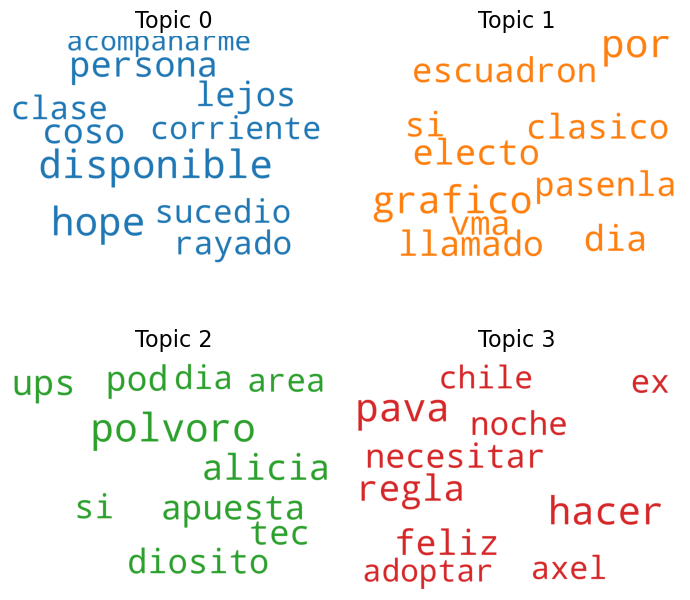

In [945]:
nube_topics(hdp_spacy.show_topics(formatted=False))

<div class="alert alert-block alert-info"> <b>Coherencia HDP ténica lemmatizer Spacy:  0.746</b></div>

In [946]:
resultados['HDP spacy']= 0.746

<a id="3.2"></a> 
## 3.2. Latent Dirchlet Allocation(LDA) (técnica stemmer)
[Tabla de contenidos](#0)

<div class="alert alert-block alert-success"> <b>LDA: </b> LDA intenta
volver hacia atrás para descubrir las categorías que generaron los tweets. LDA es un modelo probabilístico generativo, que asume un Dirichlet previo sobre los temas latentes.<br><br>
A diferencia de HDP LDA requiere la especificación de la cantidad de temas</div>

In [947]:
from gensim.models import LdaModel

In [951]:
lda_datos = procesado.copy()

In [953]:
lda_datos.head(2)

id                                              texto   
0  809927403615256576  En definitiva! Me quedé sin campo para ir a Ta...  \
1  796040775364710400  @dianalaa32 Es una escena de uno de los docume...   

       tipo       pais   data  length     hashtag       mentions   
0  Negative  CostaRica  train     110  [#percebe]             []  \
1  Positive  CostaRica  train     134          []  [@dianalaa32]   

                                             stemmer   
0  [definit, qued, camp, ir, tacar, mentaliz, que...  \
1  [escen, documental, respet, naturalez, planet,...   

                                          lemmatizer   
0  definitiva quede campo ir tacares mentalizado ...  \
1  escena documentales respetados naturaleza plan...   

                                               spacy  
0  definitivo quedar campo ir tacar mentalizado q...  
1  escena documental respetado naturaleza planet ...

In [954]:
def convert_to_list(texto):
    print(texto)
    return texto.split(" ")  


In [955]:
def create_gensim_lda_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LDA model using gensim
    Output : return LDA model
    """
    # generate LSI model
    ldamodel = LdaModel(corpus, num_topics=number_of_topics, id2word = dictionary) 
    print(ldamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return ldamodel

In [956]:
def compute_coherence_values_lda(dictionary,corpus, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LdaModel(corpus, num_topics=num_topics, id2word = dictionary, random_state = 111)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

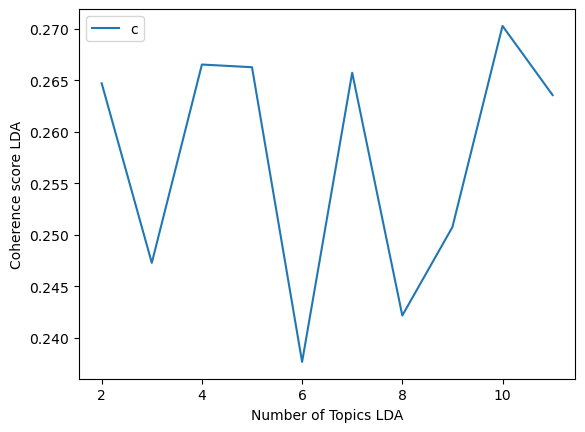

In [957]:
def plot_graph_lda(doc_clean,start, stop, step):
    #dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values_lda(dictionary, corpus,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics LDA")
    plt.ylabel("Coherence score LDA")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

start,stop,step=2,12,1
plot_graph_lda(lda_datos.stemmer,start,stop,step)

In [958]:
number_of_topics=10
words=15
lda_model=create_gensim_lda_model(lda_datos.texto,number_of_topics,words)

[(0, '0.029*"buen" + 0.017*"feliz" + 0.017*"tan" + 0.015*"dios" + 0.013*"ser" + 0.013*"igual" + 0.012*"quier" + 0.012*"si" + 0.011*"asi" + 0.011*"amig" + 0.009*"voy" + 0.008*"navid" + 0.008*"feo" + 0.008*"mejor" + 0.007*"siempr"'), (1, '0.016*"hac" + 0.016*"mal" + 0.015*"pued" + 0.015*"si" + 0.012*"bien" + 0.012*"mejor" + 0.011*"da" + 0.010*"escuch" + 0.010*"dic" + 0.009*"habl" + 0.009*"ahor" + 0.009*"sol" + 0.008*"asi" + 0.008*"esper" + 0.008*"dorm"'), (2, '0.020*"buen" + 0.019*"quier" + 0.016*"si" + 0.013*"mejor" + 0.012*"pas" + 0.011*"person" + 0.010*"jajaj" + 0.009*"ver" + 0.008*"gust" + 0.008*"ser" + 0.008*"graci" + 0.007*"mal" + 0.007*"cos" + 0.007*"amig" + 0.007*"hij"'), (3, '0.023*"si" + 0.018*"sol" + 0.018*"hac" + 0.016*"quier" + 0.015*"vez" + 0.013*"vas" + 0.013*"lleg" + 0.011*"dic" + 0.011*"ir" + 0.011*"clar" + 0.010*"buen" + 0.010*"ano" + 0.009*"peor" + 0.009*"hoy" + 0.008*"tiemp"'), (4, '0.030*"nuev" + 0.020*"ano" + 0.019*"buen" + 0.015*"pas" + 0.015*"feliz" + 0.011*"regal

In [959]:
CoherenceModel(model=lda_model, texts=precorpus, dictionary=dictionary, coherence='c_v').get_coherence()

0.2570390175736385

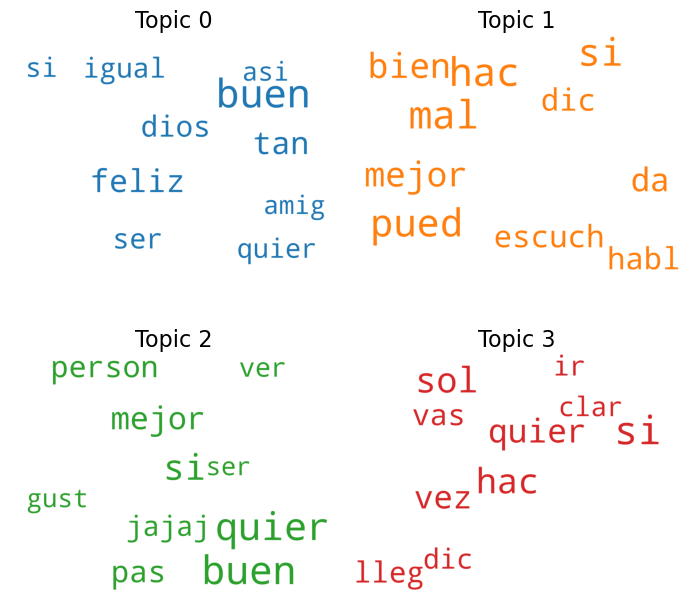

In [960]:
nube_topics(lda_model.show_topics(formatted=False))

<div class="alert alert-block alert-info"> <b>Coherencia LDA ténica stemmer:  0.257</b></div>

In [962]:
resultados['LDA stemmer'] = 0.257

<a id="3.3"></a> 
## 3.3. Latent Dirchlet Allocation(LDA) (técnica lemmatizer Stanza)
[Tabla de contenidos](#0)

In [129]:
procesado.head(3)

id                                              texto   
0  809927403615256576  En definitiva! Me quedé sin campo para ir a Ta...  \
1  796040775364710400  @dianalaa32 Es una escena de uno de los docume...   
2  802912779854352384  Qué feo es tener que terminar con alguien; y m...   

       tipo       pais   data  length     hashtag       mentions   
0  Negative  CostaRica  train     110  [#percebe]             []  \
1  Positive  CostaRica  train     134          []  [@dianalaa32]   
2  Negative  CostaRica  train     117          []             []   

                                             stemmer   
0  [definit, qued, camp, ir, tacar, mentaliz, que...  \
1  [escen, documental, respet, naturalez, planet,...   
2  [feo, ten, termin, algui, dos, person, aun, am...   

                                          lemmatizer  
0  [definitivo, quedar, campo, ir, tacar, mentali...  
1  [escena, documental, respetado, naturaleza, pl...  
2  [feo, tener, terminar, alguien, dos, persona, ...

In [130]:
def create_gensim_lda_model_lemmatizer(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LDA model using gensim
    Output : return LDA model
    """
    # generate LSI model
    ldamodel = LdaModel(corpus_lem, num_topics=number_of_topics, id2word = dictionary_lem) 
    print(ldamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return ldamodel

In [131]:
def compute_coherence_values_lda_lemmatizer(dictionary_lem,corpus_lem, doc_clean, stop, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LdaModel(corpus_lem, num_topics=num_topics, id2word = dictionary_lem, random_state = 111)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary_lem, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

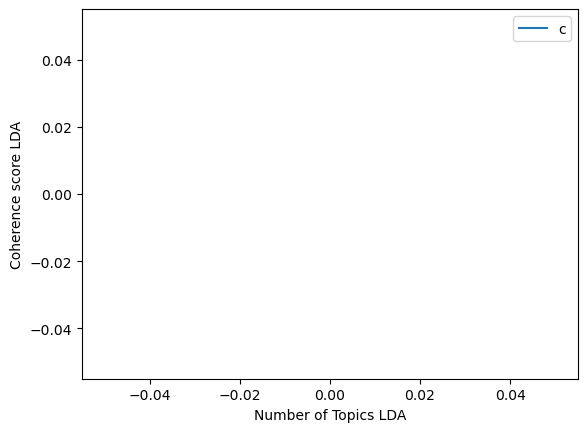

In [136]:
def plot_graph_lda_lemmatizer(doc_clean,start, stop, step):
    model_list, coherence_values = compute_coherence_values_lda_lemmatizer(dictionary_lem, corpus_lem,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score LDA lemmatizer")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

start,stop,step=2,10,1
plot_graph_lda(lda_datos.lemmatizer,start,stop,step)

In [137]:
number_of_topics=4
words=15
lda_model_lem=create_gensim_lda_model_lemmatizer(procesado.lemmatizer,number_of_topics,words)

[(0, '0.016*"ir" + 0.015*"mejor" + 0.012*"poder" + 0.012*"hacer" + 0.012*"él" + 0.012*"nuevo" + 0.011*"dar" + 0.009*"manana" + 0.009*"ahora" + 0.008*"ano" + 0.007*"igual" + 0.007*"si" + 0.007*"buen" + 0.007*"menos" + 0.007*"ver"'), (1, '0.035*"ir" + 0.021*"querer" + 0.021*"ver" + 0.015*"si" + 0.014*"hacer" + 0.014*"solo" + 0.013*"dia" + 0.012*"gracias" + 0.012*"buen" + 0.011*"poder" + 0.010*"yo" + 0.010*"lindo" + 0.010*"decir" + 0.010*"ser" + 0.009*"él"'), (2, '0.014*"si" + 0.013*"él" + 0.013*"hacer" + 0.012*"buen" + 0.011*"dar" + 0.009*"decir" + 0.008*"cosa" + 0.008*"mas" + 0.008*"poder" + 0.008*"mejor" + 0.007*"saber" + 0.007*"esperar" + 0.007*"solo" + 0.007*"ir" + 0.007*"persona"'), (3, '0.028*"buen" + 0.019*"feliz" + 0.017*"ver" + 0.015*"dia" + 0.014*"hacer" + 0.012*"hoy" + 0.011*"decir" + 0.011*"ano" + 0.011*"tanto" + 0.010*"ser" + 0.010*"si" + 0.009*"asi" + 0.009*"ir" + 0.009*"querer" + 0.008*"pasar"')]


In [138]:
CoherenceModel(model=lda_model_lem, texts=precorpus_lem, dictionary=dictionary_lem, coherence='c_v').get_coherence()

0.31278579993890593

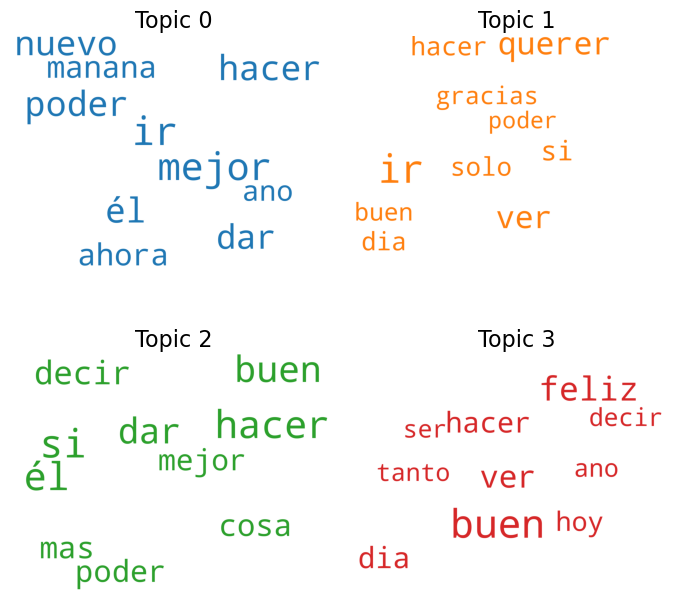

In [209]:
nube_topics(lda_model_lem.show_topics(formatted=False))

<div class="alert alert-block alert-info"> <b>Coherencia LDA ténica lemmetizer Stanza:  0.312</b></div>

In [1133]:
resultados['LDA lematizer Stanza'] = 0.312

<a id="3.4"></a> 
## 3.4. Latent Dirchlet Allocation(LDA) (técnica lemmatizer Spacy)
[Tabla de contenidos](#0)

In [976]:
lda_datos.head(2)

id                                              texto   
0  809927403615256576  En definitiva! Me quedé sin campo para ir a Ta...  \
1  796040775364710400  @dianalaa32 Es una escena de uno de los docume...   

       tipo       pais   data  length     hashtag       mentions   
0  Negative  CostaRica  train     110  [#percebe]             []  \
1  Positive  CostaRica  train     134          []  [@dianalaa32]   

                                             stemmer   
0  [definit, qued, camp, ir, tacar, mentaliz, que...  \
1  [escen, documental, respet, naturalez, planet,...   

                                          lemmatizer   
0  definitiva quede campo ir tacares mentalizado ...  \
1  escena documentales respetados naturaleza plan...   

                                               spacy  
0  definitivo quedar campo ir tacar mentalizado q...  
1  escena documental respetado naturaleza planet ...

In [971]:
def create_gensim_lda_model_spacy(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LDA model using gensim
    Output : return LDA model
    """
    # generate LSI model
    ldamodel_spacy = LdaModel(corpus_spacy, num_topics=number_of_topics, id2word = dictionary_spacy) 
    print(ldamodel_spacy.print_topics(num_topics=number_of_topics, num_words=words))
    return ldamodel_spacy

In [972]:
def compute_coherence_values_lda_spacy(dictionary_spacy,corpus_spacy, doc_clean, stop, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LdaModel(corpus_spacy, num_topics=num_topics, id2word = dictionary_spacy, random_state = 111)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary_spacy, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

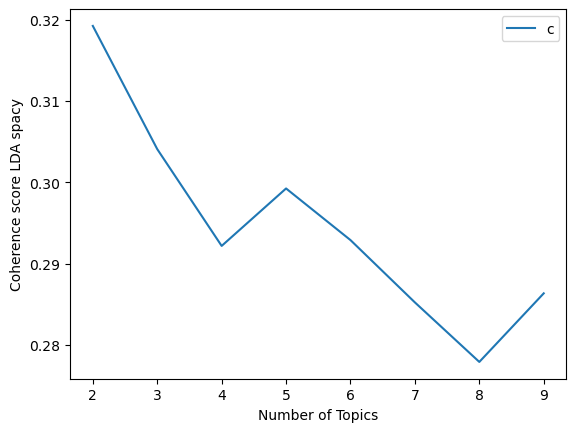

In [980]:
def plot_graph_lda_spacy(doc_clean,start, stop, step):
    model_list, coherence_values = compute_coherence_values_lda_spacy(dictionary_spacy, corpus_spacy,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score LDA spacy")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

start,stop,step=2,10,1
plot_graph_lda_spacy(precorpus_spacy,start,stop,step)

In [988]:
number_of_topics=2
words=15
lda_model_spacy=create_gensim_lda_model_spacy(precorpus_spacy,number_of_topics,words)

[(0, '0.021*"ir" + 0.014*"ver" + 0.011*"hacer" + 0.011*"querer" + 0.009*"solo" + 0.009*"tanto" + 0.008*"decir" + 0.008*"poder" + 0.008*"asi" + 0.007*"dia" + 0.007*"él" + 0.007*"dar" + 0.007*"buen" + 0.006*"bueno" + 0.005*"si"'), (1, '0.019*"si" + 0.014*"ir" + 0.013*"él" + 0.013*"hacer" + 0.012*"ver" + 0.011*"dia" + 0.011*"ano" + 0.010*"feliz" + 0.010*"mejor" + 0.010*"nuevo" + 0.009*"buen" + 0.009*"ser" + 0.008*"bien" + 0.008*"hoy" + 0.008*"decir"')]


In [989]:
CoherenceModel(model=lda_model_spacy, texts=precorpus_spacy, dictionary=dictionary_spacy, coherence='c_v').get_coherence()

0.3128480795349545

In [984]:
lda_model_spacy.show_topics(formatted=False)

[(0,
  [('hacer', 0.017960558),
   ('ver', 0.0143993385),
   ('él', 0.012195586),
   ('querer', 0.012051199),
   ('si', 0.010306939),
   ('decir', 0.009987715),
   ('asi', 0.008486359),
   ('bueno', 0.008153421),
   ('mejor', 0.007550372),
   ('dar', 0.0075213914)]),
 (1,
  [('ir', 0.027777584),
   ('dia', 0.014500318),
   ('si', 0.013435361),
   ('buen', 0.012773308),
   ('ver', 0.011902518),
   ('solo', 0.0110801365),
   ('feliz', 0.010265135),
   ('hoy', 0.010167253),
   ('ano', 0.009586877),
   ('poder', 0.008667243)])]

IndexError: list index out of range

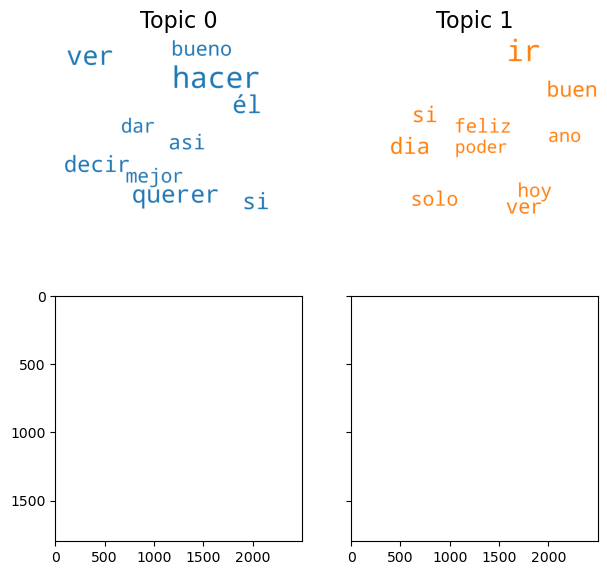

In [985]:
#nube_topics(lda_model_spacy.show_topics(formatted=False))

<div class="alert alert-block alert-info"> <b>Coherencia LDA ténica lemmetizer Spacy:  0.313</b></div>

In [994]:
resultados['LDA lematizer Spacy'] = 0.313

<a id="3.5"></a> 
## 3.5. Latent Semantic Indexin(LSI) (técnica Stemmer)
[Tabla de contenidos](#0)

<div class="alert alert-block alert-success"> <b>LSI: </b>También conocido como análisis semántico latente, LSA aprende temas latentes realizando una descomposición matricial (SVD) de las palabras que aparecen en los textos.
<br><br>
En la práctica, LSI es mucho más rápido de entrenar que LDA, pero tiene menor precisión.
</div>



In [677]:
from gensim.models import LsiModel
from gensim import similarities

In [678]:
dictionary

In [995]:
lsi_datos = procesado.copy()

In [680]:
xs = procesado.stemmer
print(xs)
s = ''.join(str(x) for x in xs)


0      definitiva quede campo ir tacares mentalizado ...
1      escena documentales respetados naturaleza plan...
2      feo tener terminar alguien dos personas aun am...
3      oido mcdonalds mejor manequin challenge visto ...
4      aceptar hundiendo consumismo nueva macbok pro ...
                             ...                        
459        aca seba peor sismografo da datos tiempo real
460            hack imposible sacarme ac  gano confianza
461    nadie vende the last of us remastered menos do...
462    propuse dejar redes salidas amp estudiar histo...
463    si voy media hora vas reconocer musculosa hava...
Name: stemmer, Length: 7245, dtype: object


In [997]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LSI model
    return dictionary,doc_term_matrix


In [998]:
def create_gensim_lsi_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
   # dictionary_lsi,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSI model
    lsimodel = LsiModel(corpus, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsimodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsimodel

In [999]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSI model
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

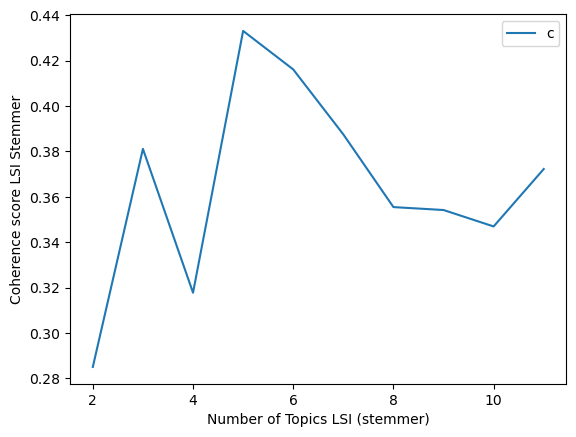

In [1000]:
def plot_graph(doc_clean,start, stop, step):
   # dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, corpus,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics LSI (stemmer)")
    plt.ylabel("Coherence score LSI Stemmer")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

start,stop,step=2,12,1
plot_graph(lsi_datos.stemmer,start,stop,step)

In [1009]:
number_of_topics=5
words=3
lsi_model=create_gensim_lsi_model(lsi_datos.stemmer,number_of_topics,words)

[(0, '-0.494*"buen" + -0.453*"si" + -0.264*"hac"'), (1, '-0.757*"buen" + 0.579*"si" + 0.122*"hac"'), (2, '0.601*"si" + -0.594*"hac" + 0.291*"buen"'), (3, '-0.624*"hac" + 0.464*"quier" + 0.404*"sol"'), (4, '0.680*"quier" + -0.343*"pas" + -0.312*"mejor"')]


In [1010]:
CoherenceModel(model=lsi_model, texts=precorpus, dictionary=dictionary, coherence='c_v').get_coherence()

0.4131239318487996

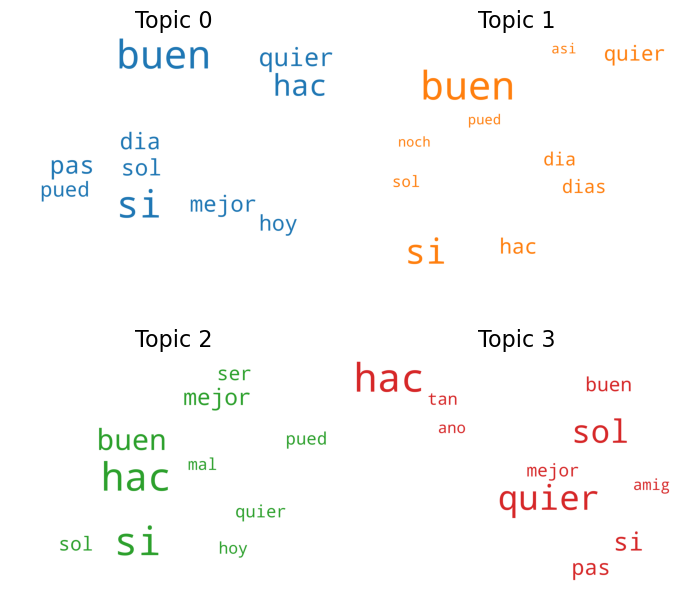

In [1014]:
lsi_topics_ = lsi_model.show_topics(formatted=False)
lsi_topics_ = [(index, [(word, abs(value)) for word, value in inner_list]) for index, inner_list in lsi_topics_]
nube_topics(lsi_topics_)

<div class="alert alert-block alert-info"> <b>Coherencia LSI técnica stemmer:  0.413
    </b></div>

In [1012]:
resultados['LSI stemmer'] = 0.413

<a id="3.6"></a> 
## 3.6. Latent Semantic Indexin(LSI) (técnica Lemmatizer Stanza)
[Tabla de contenidos](#0)

In [211]:
def create_gensim_lsi_model_lemmatizer(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
   # dictionary_lsi,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSI model
    lsimodel = LsiModel(corpus_lem, num_topics=number_of_topics, id2word = dictionary_lem)  # train model
    print(lsimodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsimodel

In [212]:
def compute_coherence_values_lsi_lemmatizer(dictionary_lem, corpus_lem, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(corpus_lem, num_topics=num_topics, id2word = dictionary_lem)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary_lem, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [213]:
print(dictionary_lem)

Dictionary<4062 unique tokens: ['campo', 'definitivo', 'ir', 'quedar', 'querer']...>


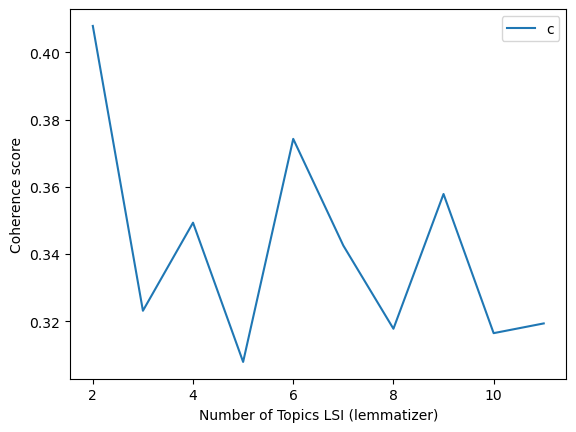

In [214]:
def plot_graph(doc_clean,start, stop, step):
    model_list, coherence_values = compute_coherence_values(dictionary_lem, corpus_lem,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics LSI (lemmatizer)")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

start,stop,step=2,12,1
plot_graph(procesado.lemmatizer,start,stop,step)

In [221]:
number_of_topics=6
words=10
lsi_model_lemmatizer=create_gensim_lsi_model_lemmatizer(procesado.lemmatizer,number_of_topics,words)

[(0, '-0.546*"ir" + -0.310*"hacer" + -0.287*"ver" + -0.283*"si" + -0.259*"buen" + -0.188*"poder" + -0.180*"él" + -0.175*"querer" + -0.156*"dia" + -0.141*"decir"'), (1, '0.809*"ir" + -0.308*"hacer" + -0.300*"buen" + -0.178*"si" + -0.177*"ver" + -0.113*"dia" + -0.105*"él" + -0.096*"poder" + -0.078*"querer" + -0.066*"decir"'), (2, '-0.770*"buen" + 0.488*"hacer" + -0.300*"dia" + 0.145*"ver" + 0.105*"él" + 0.078*"querer" + 0.078*"poder" + 0.072*"si" + -0.058*"ir" + -0.052*"noche"'), (3, '-0.622*"hacer" + 0.537*"si" + 0.454*"ver" + -0.175*"buen" + 0.161*"querer" + -0.132*"dia" + -0.089*"ir" + -0.087*"ano" + 0.062*"decir" + -0.052*"feliz"'), (4, '0.707*"ver" + -0.671*"si" + 0.082*"poder" + -0.078*"hacer" + -0.065*"decir" + -0.063*"saber" + 0.048*"él" + -0.042*"ser" + -0.039*"bien" + 0.036*"vez"'), (5, '-0.417*"poder" + -0.412*"querer" + 0.340*"ver" + 0.331*"hacer" + 0.303*"si" + -0.269*"ser" + -0.198*"él" + -0.171*"solo" + -0.166*"decir" + -0.152*"yo"')]


In [222]:
CoherenceModel(model=lsi_model_lemmatizer, texts=precorpus_lem, dictionary=dictionary_lem, coherence='c_v').get_coherence()

0.3839851638055896

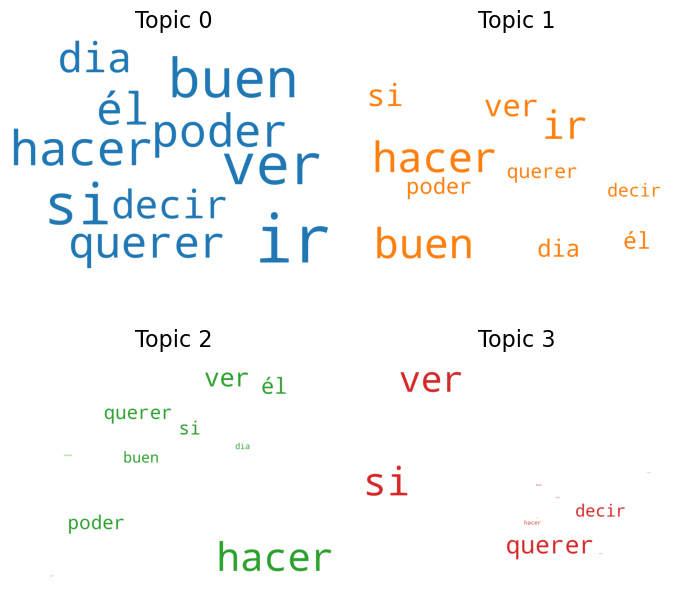

In [223]:
nube_topics(lsi_model_lemmatizer.show_topics(formatted=False))

<div class="alert alert-block alert-info"> <b>Coherencia LSI técnica lemmetizer:  0.384</b></div>

In [1135]:
resultados['LSI Stanza'] = 0.384

<a id="3.7"></a> 
## 3.7. Latent Semantic Indexin(LSI) (técnica Lemmatizer Spacy)
[Tabla de contenidos](#0)

In [1019]:
def create_gensim_lsi_model_spacy(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
   # dictionary_lsi,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSI model
    lsimodel_spacy = LsiModel(corpus_spacy, num_topics=number_of_topics, id2word = dictionary_spacy)
    print(lsimodel_spacy.print_topics(num_topics=number_of_topics, num_words=words))
    return lsimodel_spacy

In [1020]:
def compute_coherence_values_lsi_spacy(dictionary_spacy, corpus_spacy, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSI model
        model = LsiModel(corpus_spacy, num_topics=num_topics, id2word = dictionary_spacy)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary_spacy, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

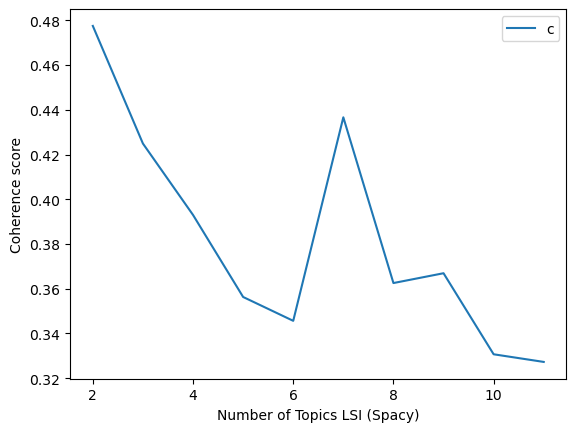

In [1022]:
def plot_graph_lsi_spacy(doc_clean,start, stop, step):
    model_list, coherence_values = compute_coherence_values_lsi_spacy(dictionary_spacy, corpus_spacy,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics LSI (Spacy)")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

start,stop,step=2,12,1
plot_graph_lsi_spacy(precorpus_spacy,start,stop,step)

In [1053]:
number_of_topics=7
words=10
lsi_model_spacy=create_gensim_lsi_model_spacy(precorpus_spacy,number_of_topics,words)

[(0, '-0.578*"ir" + -0.310*"ver" + -0.310*"si" + -0.305*"hacer" + -0.232*"él" + -0.158*"querer" + -0.156*"poder" + -0.148*"dia" + -0.133*"decir" + -0.113*"ser"'), (1, '0.787*"ir" + -0.344*"hacer" + -0.315*"si" + -0.246*"ver" + -0.153*"él" + -0.077*"querer" + -0.073*"dia" + -0.072*"poder" + -0.067*"mejor" + -0.064*"buen"'), (2, '0.686*"hacer" + -0.651*"si" + -0.221*"ver" + 0.092*"dia" + 0.087*"ano" + -0.069*"querer" + 0.051*"él" + 0.050*"feliz" + 0.049*"mejor" + 0.043*"ser"'), (3, '0.793*"ver" + -0.516*"si" + -0.226*"hacer" + 0.134*"él" + -0.058*"ser" + -0.053*"feliz" + -0.050*"ano" + -0.044*"ir" + -0.040*"dia" + -0.039*"saber"'), (4, '0.680*"dia" + 0.416*"buen" + -0.367*"hacer" + 0.188*"hoy" + -0.183*"si" + 0.168*"ser" + -0.153*"ver" + 0.125*"feliz" + -0.117*"ir" + 0.098*"ano"'), (5, '0.631*"él" + -0.321*"ver" + 0.299*"querer" + -0.275*"hacer" + -0.244*"dia" + 0.193*"poder" + -0.179*"si" + 0.178*"solo" + -0.178*"buen" + 0.162*"decir"'), (6, '-0.636*"él" + 0.468*"querer" + 0.255*"ser" +

In [1054]:
CoherenceModel(model=lsi_model_spacy, texts=precorpus_spacy, dictionary=dictionary_spacy, coherence='c_v').get_coherence()

0.3897875279681159

<div class="alert alert-block alert-info"> <b>Coherencia LSI Spacy:  0.39</b></div>

In [ ]:
lsi_topics__ = lsi_model_spacy.show_topics(formatted=False)
lsi_topics__= [(index, [(word, abs(value)) for word, value in inner_list]) for index, inner_list in lsi_topics__]
nube_topics(lsi_model_spacy.show_topics(formatted=False))

In [1056]:
resultados['LSI Spacy'] = 0.39

<a id="3.4"></a> 
## 3.8. K-means stemmer
[Tabla de contenidos](#0)

In [1059]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [1060]:
kmeans_datos = procesado.copy()

In [1061]:
kmeans_datos

id                                              texto   
0    809927403615256576  En definitiva! Me quedé sin campo para ir a Ta...  \
1    796040775364710400  @dianalaa32 Es una escena de uno de los docume...   
2    802912779854352384  Qué feo es tener que terminar con alguien; y m...   
3    800835505717972992  Oído en McDonalds "el mejor mannequin challeng...   
4    791640101751230464  Tengo que aceptar que me esta hundiendo el con...   
..                  ...                                                ...   
459  801994750089904128  @sebatramp Acá también, Seba ???? Para peor el...   
460  801561284420521989  @Phoyu_Agustina no soy hack pero es imposible ...   
461  805712525727645696  Nadie te vende un The Last of Us Remastered po...   
462  796172973967310848  Me propuse dejar las redes, las salidas &amp; ...   
463  811595209029124096  @irenichus siii! Voy como en media hora. Me va...   

         tipo       pais   data  length         hashtag           mentions   
0    Negative  CostaRica  train     110      [#percebe]                 []  \
1    Positive  CostaRica  train     134              []      [@dianalaa32]   
2    Negative  CostaRica  train     117              []                 []   
3    Negative  CostaRica  train     136              []                 []   
4     Neutral  CostaRica  train     132              []                 []   
..        ...        ...    ...     ...             ...                ...   
459  Negative    Uruguay   test      88              []       [@sebatramp]   
460   Neutral    Uruguay   test      90              []  [@Phoyu_Agustina]   
461  Negative    Uruguay   test      90              []                 []   
462   Neutral    Uruguay   test     105              []                 []   
463  Positive    Uruguay   test     117  [#foreverpink]       [@irenichus]   

                                               stemmer   
0    [definit, qued, camp, ir, tacar, mentaliz, que...  \
1    [escen, documental, respet, naturalez, planet,...   
2    [feo, ten, termin, algui, dos, person, aun, am...   
3    [oid, mcdonalds, mejor, manequin, challeng, vi...   
4    [acept, hund, consum, nuev, macbok, pro, gopr,...   
..                                                 ...   
459  [aca, seb, peor, sismograf, da, dat, tiemp, real]   
460              [hack, impos, sac, ac, gan, confianz]   
461  [nadi, vend, the, last, of, us, remaster, men,...   
462  [propus, dej, red, sal, amp, estudi, histori, ...   
463  [si, voy, medi, hor, vas, reconoc, muscul, hav...   

                                            lemmatizer   
0    definitiva quede campo ir tacares mentalizado ...  \
1    escena documentales respetados naturaleza plan...   
2    feo tener terminar alguien dos personas aun am...   
3    oido mcdonalds mejor manequin challenge visto ...   
4    aceptar hundiendo consumismo nueva macbok pro ...   
..                                                 ...   
459      aca seba peor sismografo da datos tiempo real   
460          hack imposible sacarme ac  gano confianza   
461  nadie vende the last of us remastered menos do...   
462  propuse dejar redes salidas amp estudiar histo...   
463  si voy media hora vas reconocer musculosa hava...   

                                                 spacy  
0    definitivo quedar campo ir tacar mentalizado q...  
1    escena documental respetado naturaleza planet ...  
2    feo tener terminar alguien dos persona aun ama...  
3    oido mcdonalds mejor manequin challenge visto ...  
4    aceptar hundir consumismo nuevo macbok pro gop...  
..                                                 ...  
459      aca seba peor sismografo dar dato tiempo real  
460        hack imposible sacar yo ac   gano confianza  
461  nadie vender the last of us remastered menos d...  
462  propusar dejar red salida amp estudiar histori...  
463  si ir medio hora ir reconocer musculós havaian...  

[7245 rows x 11 columns]

In [1062]:
vectorizer =TfidfVectorizer()
#tfidf = vectorizer.fit_transform(kmeans_datos.stemmer.apply(lambda x: " ".join(x)))
tfidf = vectorizer.fit_transform(kmeans_datos.spacy)


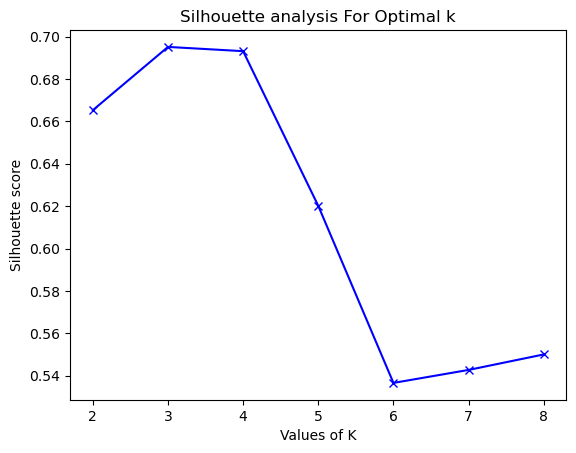

In [1063]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_avg = []
for num_clusters in range_n_clusters:
 
    # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    pca=PCA(n_components=2)
    pca_matriz = pca.fit_transform(tfidf.toarray())
    kmeans.fit(pca_matriz)
    cluster_labels = kmeans.labels_
 
    # silhouette score
    silhouette_avg.append(silhouette_score(pca_matriz, cluster_labels))

plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

In [1064]:
n_clusters = 3

In [1065]:
kmeans= KMeans(n_clusters=n_clusters)

In [1068]:
kmeans.fit(pca_matriz)

KMeans(n_clusters=3)

In [1069]:
pred_labels = kmeans.labels_

In [1070]:
centroids = kmeans.cluster_centers_ 

In [1071]:
kmeans_datos['Cluster'] = pred_labels

In [1072]:
kmeans_datos[['lemmatizer','Cluster']]

lemmatizer  Cluster
0    definitiva quede campo ir tacares mentalizado ...        1
1    escena documentales respetados naturaleza plan...        0
2    feo tener terminar alguien dos personas aun am...        0
3    oido mcdonalds mejor manequin challenge visto ...        0
4    aceptar hundiendo consumismo nueva macbok pro ...        0
..                                                 ...      ...
459      aca seba peor sismografo da datos tiempo real        0
460          hack imposible sacarme ac  gano confianza        0
461  nadie vende the last of us remastered menos do...        0
462  propuse dejar redes salidas amp estudiar histo...        0
463  si voy media hora vas reconocer musculosa hava...        1

[7245 rows x 2 columns]

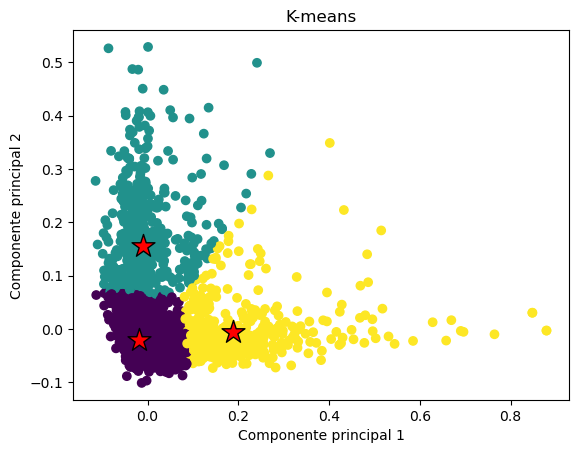

In [1073]:
plt.scatter(pca_matriz[:, 0], pca_matriz[:, 1], c=pred_labels)
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.title('K-means')
plt.scatter(
    centroids[:, 0], centroids[:, 1],
    s=300, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.show()


<div class="alert alert-block alert-info"> <b>Kmeans 3 agrupaciones principales</b></div>

In [1074]:
wcss = kmeans.inertia_
print("Suma de Cuadrados Dentro del Clúster (WCSS):", wcss)

Suma de Cuadrados Dentro del Clúster (WCSS): 22.879936251317197


In [1075]:
def convert_long_string(xs):
    s = "".join(str(x) for x in xs)
    print(s)

In [1076]:
convert_long_string('[manana, dia, libre, hacer, dormir]')

[manana, dia, libre, hacer, dormir]


In [1077]:
for cluster in range(n_clusters):
    cluster_data = kmeans_datos[kmeans_datos['Cluster'] == cluster]
    print(f"Cluster {cluster}:")
    print(cluster_data['lemmatizer'])

Cluster 0:
1      escena documentales respetados naturaleza plan...
2      feo tener terminar alguien dos personas aun am...
3      oido mcdonalds mejor manequin challenge visto ...
4      aceptar hundiendo consumismo nueva macbok pro ...
6                                             solo cucas
                             ...                        
458    puedes bajar loby solo minuto sola foto vacio ...
459        aca seba peor sismografo da datos tiempo real
460            hack imposible sacarme ac  gano confianza
461    nadie vende the last of us remastered menos do...
462    propuse dejar redes salidas amp estudiar histo...
Name: lemmatizer, Length: 5802, dtype: object
Cluster 1:
0      definitiva quede campo ir tacares mentalizado ...
5      quiero hacer spoiler hoy va ver nuevo canallo ...
13                       voy vuelta deje pampa lindisima
16                         se si funcione vemos cumplido
18     ok vea lado positivo motivo hacerle drama rest...
                    

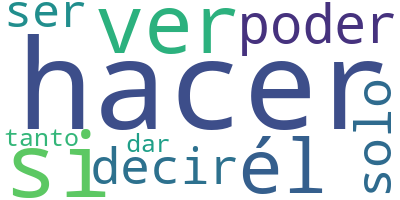

In [1118]:
nube_palabras(kmeans_datos[kmeans_datos['Cluster'] == 0].spacy)

<div class="alert alert-block alert-info"> <b>CLUSTER 0</b></div>

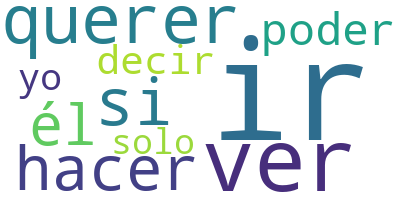

In [1119]:
nube_palabras(kmeans_datos[kmeans_datos['Cluster'] == 1].spacy)

<div class="alert alert-block alert-info"> <b>CLUSTER 1</b></div>

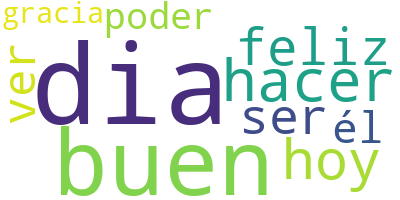

In [1123]:
nube_palabras(kmeans_datos[kmeans_datos['Cluster'] == 2].spacy)

<div class="alert alert-block alert-info"> <b>CLUSTER 2</b></div>

<a id="3.5"></a> 
## 3.5. DBSCAN
[Tabla de contenidos](#0)

In [1081]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

In [1082]:
dbscan_datos = procesado

In [1084]:
vectorizer =TfidfVectorizer()
tfidf = vectorizer.fit_transform(kmeans_datos.spacy)

In [1085]:
pca=PCA(n_components=2)
pca_matriz = pca.fit_transform(tfidf.toarray())
dbscan = DBSCAN(eps=0.01, min_samples=45)
dbscan.fit(pca_matriz)
labels = dbscan.labels_

In [1086]:
dbscan_datos["Cluster"] = labels

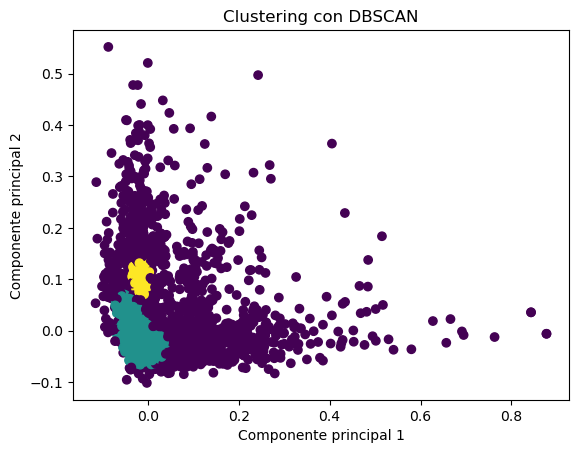

In [1087]:
plt.scatter(pca_matriz[:, 0], pca_matriz[:, 1], c=labels)
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.title('Clustering con DBSCAN')
plt.show()

In [1095]:
list_labels = set(labels)
for cluster in list_labels:
    print(cluster)
    cluster_data = dbscan_datos[dbscan_datos['Cluster'] == cluster]
    print(f"{len(cluster_data)} Comentarios en Cluster {cluster}:")
    print(dbscan_datos['spacy'])
    print("-----------------------------------")

0
5451 Comentarios en Cluster 0:
0      definitivo quedar campo ir tacar mentalizado q...
1      escena documental respetado naturaleza planet ...
2      feo tener terminar alguien dos persona aun ama...
3      oido mcdonalds mejor manequin challenge visto ...
4      aceptar hundir consumismo nuevo macbok pro gop...
                             ...                        
459        aca seba peor sismografo dar dato tiempo real
460          hack imposible sacar yo ac   gano confianza
461    nadie vender the last of us remastered menos d...
462    propusar dejar red salida amp estudiar histori...
463    si ir medio hora ir reconocer musculós havaian...
Name: spacy, Length: 7245, dtype: object
-----------------------------------
1
269 Comentarios en Cluster 1:
0      definitivo quedar campo ir tacar mentalizado q...
1      escena documental respetado naturaleza planet ...
2      feo tener terminar alguien dos persona aun ama...
3      oido mcdonalds mejor manequin challenge visto ...
4  

In [1097]:
dbscan_datos[dbscan_datos['Cluster'] == 0].spacy

1      escena documental respetado naturaleza planet ...
2      feo tener terminar alguien dos persona aun ama...
3      oido mcdonalds mejor manequin challenge visto ...
4      aceptar hundir consumismo nuevo macbok pro gop...
6                                              solo cuca
                             ...                        
458    poder bajar loby solo minuto solo foto vacio a...
459        aca seba peor sismografo dar dato tiempo real
460          hack imposible sacar yo ac   gano confianza
461    nadie vender the last of us remastered menos d...
462    propusar dejar red salida amp estudiar histori...
Name: spacy, Length: 5451, dtype: object

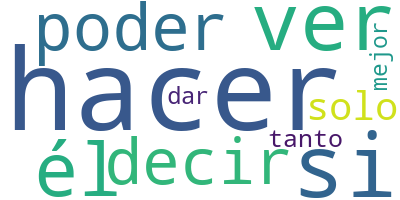

In [1100]:
nube_palabras(dbscan_datos[dbscan_datos['Cluster'] == 0].spacy)

<div class="alert alert-block alert-info"> <b>CLUSTER 0</b></div>

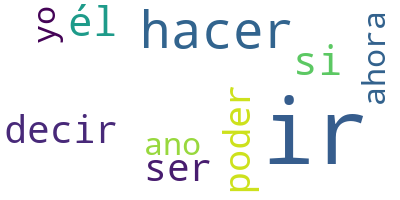

In [1101]:
nube_palabras(dbscan_datos[dbscan_datos['Cluster'] == 1].spacy)

<div class="alert alert-block alert-info"> <b>CLUSTER 1</b></div>

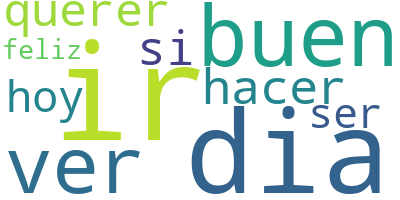

In [1102]:
nube_palabras(dbscan_datos[dbscan_datos['Cluster'] == -1].spacy)

<div class="alert alert-block alert-info"> <b>CLUSTER -1</b></div>

<a id="5"></a>
# 5.Clasificación de los twits
[Tabla de contenidos](#0)
<div class="alert alert-block alert-info"> <b></b>Se pueden utilizar técnicas como análisis de sentimientos basado en palabras clave, clasificadores de aprendizaje automático (por ejemplo, Naive Bayes) o modelos de procesamiento del lenguaje natural (por ejemplo, BERT). Explicar la técnica utilizada y proporcionar el resultado de la clasificación.</div>

<a id="5.1"></a> 
## 5.1. BERT
[Tabla de contenidos](#0)

In [1067]:
!pip install transformers

     ---------------------------------------- 7.1/7.1 MB 619.3 kB/s eta 0:00:00
     ------------------------------------ 224.5/224.5 kB 527.7 kB/s eta 0:00:00
     ---------------------------------------- 3.5/3.5 MB 318.1 kB/s eta 0:00:00


In [1103]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification

In [1107]:
model_name = 'dccuchile/bert-base-spanish-wwm-uncased'

In [1108]:
tokenizer = BertTokenizer.from_pretrained(model_name)

In [1110]:
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuc

In [1111]:
# Preprocesar el texto
def preprocess_text(text):
    encoded_text = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return encoded_text['input_ids'], encoded_text['attention_mask']

 

In [1112]:
# Clasificar
def classify_tweet(text):
    input_ids, attention_mask = preprocess_text(text)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1)
        predicted_class = predicted_labels.item()
    return predicted_class

In [1113]:
# Analisis de sentimiento
def perform_sentiment_analysis(procesado):
    sentiment_mapping = {0: 'Negative', 1: 'Positive', 2: 'Neutral'}
    procesado['sentiment'] = procesado['spacy'].apply(classify_tweet)
    procesado['sentiment'] = procesado['sentiment'].map(sentiment_mapping)
    return procesado

 

# Datos Train
train_procesado = procesado.loc[procesado['data'] == 'train']
# Datos Train
test_procesado = procesado.loc[procesado['data'] == 'test']

 

# Aplicar analisis de sentimiento en datos Train
train_procesado = perform_sentiment_analysis(train_procesado)
# Aplicar analisis de sentimiento en datos Test
test_procesado = perform_sentiment_analysis(test_procesado)

 

# Calculate accuracy on the train set
train_accuracy = accuracy_score(train_procesado['tipo'], train_procesado['sentiment'])
print(f"Accuracy: {train_accuracy}")

 

# Calculate accuracy on the test set
test_accuracy = accuracy_score(test_procesado['tipo'], test_procesado['sentiment'])
print(f"Accuracy: {test_accuracy}")

C:\Users\evill\AppData\Local\Temp\ipykernel_22388\223620554.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\evill\AppData\Local\Temp\ipykernel_22388\223620554.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\evill\AppData\Local\Temp\ipykernel_22388\223620554.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

Accuracy: 0.3119533527696793
Accuracy: 0.30863692181743757


<div class="alert alert-block alert-info"> <b>TEST ACCURACY: 0,308</b></div>
<div class="alert alert-block alert-info"> <b>TRAIN ACCURACY: 0,311</b></div>

In [1117]:
procesado.head(10)

id                                              texto   
0  809927403615256576  En definitiva! Me quedé sin campo para ir a Ta...  \
1  796040775364710400  @dianalaa32 Es una escena de uno de los docume...   
2  802912779854352384  Qué feo es tener que terminar con alguien; y m...   
3  800835505717972992  Oído en McDonalds "el mejor mannequin challeng...   
4  791640101751230464  Tengo que aceptar que me esta hundiendo el con...   
5  758451150349664256  Mmm no quiero hacer spoiler pero hoy va a ver ...   
6  760715780732354561                     @itsdylanjos yo solo las cucas   
7  800388250942709760                 @Adri_hdezv Bby muy duro la verdad   
8  801870717969174529             @_AlejandroDP no estoy en la zona roja   
9  814853214050906112     Quiero como tener carro para hacer todo rápido   

       tipo       pais   data  length     hashtag        mentions   
0  Negative  CostaRica  train     110  [#percebe]              []  \
1  Positive  CostaRica  train     134          []   [@dianalaa32]   
2  Negative  CostaRica  train     117          []              []   
3  Negative  CostaRica  train     136          []              []   
4   Neutral  CostaRica  train     132          []              []   
5   Neutral  CostaRica  train     125          []              []   
6   Neutral  CostaRica  train      30          []  [@itsdylanjos]   
7  Negative  CostaRica  train      34          []   [@Adri_hdezv]   
8   Neutral  CostaRica  train      38          []              []   
9   Neutral  CostaRica  train      46          []              []   

                                             stemmer   
0  [definit, qued, camp, ir, tacar, mentaliz, que...  \
1  [escen, documental, respet, naturalez, planet,...   
2  [feo, ten, termin, algui, dos, person, aun, am...   
3  [oid, mcdonalds, mejor, manequin, challeng, vi...   
4  [acept, hund, consum, nuev, macbok, pro, gopr,...   
5  [quier, hac, spoil, hoy, va, ver, nuev, canall...   
6                                         [sol, cuc]   
7                                        [dur, verd]   
8                                         [zon, roj]   
9                       [quier, ten, carr, hac, rap]   

                                          lemmatizer   
0  definitiva quede campo ir tacares mentalizado ...  \
1  escena documentales respetados naturaleza plan...   
2  feo tener terminar alguien dos personas aun am...   
3  oido mcdonalds mejor manequin challenge visto ...   
4  aceptar hundiendo consumismo nueva macbok pro ...   
5  quiero hacer spoiler hoy va ver nuevo canallo ...   
6                                         solo cucas   
7                                        duro verdad   
8                                          zona roja   
9                    quiero tener carro hacer rapido   

                                               spacy  Cluster  
0  definitivo quedar campo ir tacar mentalizado q...       -1  
1  escena documental respetado naturaleza planet ...        0  
2  feo tener terminar alguien dos persona aun ama...        0  
3  oido mcdonalds mejor manequin challenge visto ...        0  
4  aceptar hundir consumismo nuevo macbok pro gop...        0  
5  querer hacer spoiler hoy ir ver nuevo canallo ...       -1  
6                                          solo cuca        0  
7                                        duro verdad        0  
8                                          zona rojo        0  
9                    querer tener carro hacer rapido        0

<a id="6"></a>
# 6.Sentimiento mayoritario en los tweets
[Tabla de contenidos](#0)
<div class="alert alert-block alert-info"> <b></b>Mostrar porcentajes de tweets clasificados como positivos, negativos o neutros</div>

In [399]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\evill\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [541]:
SentimentIntensityAnalyzer_data  = procesado.copy()

In [542]:
SentimentIntensityAnalyzer_data

id                                              texto   
0    809927403615256576  En definitiva! Me quedé sin campo para ir a Ta...  \
1    796040775364710400  @dianalaa32 Es una escena de uno de los docume...   
2    802912779854352384  Qué feo es tener que terminar con alguien; y m...   
3    800835505717972992  Oído en McDonalds "el mejor mannequin challeng...   
4    791640101751230464  Tengo que aceptar que me esta hundiendo el con...   
..                  ...                                                ...   
459  801994750089904128  @sebatramp Acá también, Seba ???? Para peor el...   
460  801561284420521989  @Phoyu_Agustina no soy hack pero es imposible ...   
461  805712525727645696  Nadie te vende un The Last of Us Remastered po...   
462  796172973967310848  Me propuse dejar las redes, las salidas &amp; ...   
463  811595209029124096  @irenichus siii! Voy como en media hora. Me va...   

         tipo       pais   data  length         hashtag           mentions   
0    Negative  CostaRica  train     110      [#percebe]                 []  \
1    Positive  CostaRica  train     134              []      [@dianalaa32]   
2    Negative  CostaRica  train     117              []                 []   
3    Negative  CostaRica  train     136              []                 []   
4     Neutral  CostaRica  train     132              []                 []   
..        ...        ...    ...     ...             ...                ...   
459  Negative    Uruguay   test      88              []       [@sebatramp]   
460   Neutral    Uruguay   test      90              []  [@Phoyu_Agustina]   
461  Negative    Uruguay   test      90              []                 []   
462   Neutral    Uruguay   test     105              []                 []   
463  Positive    Uruguay   test     117  [#foreverpink]       [@irenichus]   

                                               stemmer   
0    definitiva quede campo ir tacares mentalizado ...  \
1    escena documentales respetados naturaleza plan...   
2    feo tener terminar alguien dos personas aun am...   
3    oido mcdonalds mejor manequin challenge visto ...   
4    aceptar hundiendo consumismo nueva macbok pro ...   
..                                                 ...   
459      aca seba peor sismografo da datos tiempo real   
460          hack imposible sacarme ac  gano confianza   
461  nadie vende the last of us remastered menos do...   
462  propuse dejar redes salidas amp estudiar histo...   
463  si voy media hora vas reconocer musculosa hava...   

                                            lemmatizer  
0    definitiva quede campo ir tacares mentalizado ...  
1    escena documentales respetados naturaleza plan...  
2    feo tener terminar alguien dos personas aun am...  
3    oido mcdonalds mejor manequin challenge visto ...  
4    aceptar hundiendo consumismo nueva macbok pro ...  
..                                                 ...  
459      aca seba peor sismografo da datos tiempo real  
460          hack imposible sacarme ac  gano confianza  
461  nadie vende the last of us remastered menos do...  
462  propuse dejar redes salidas amp estudiar histo...  
463  si voy media hora vas reconocer musculosa hava...  

[7245 rows x 10 columns]

In [543]:
def sentiment_classification(x):
    if x>0:
        return 'Positivo'
    elif x< 0:
        return 'Negativo'
    else:
        return 'Neutro'

In [544]:
#def unir_texto(x):
 #   return ' '.join(x)

In [545]:
sentiment = SentimentIntensityAnalyzer()

In [546]:
SentimentIntensityAnalyzer_data['neg'] = [sentiment.polarity_scores(texto)['neg'] for texto in SentimentIntensityAnalyzer_data.texto]

In [547]:
SentimentIntensityAnalyzer_data['pos'] = [sentiment.polarity_scores(texto)['pos'] for texto in SentimentIntensityAnalyzer_data.texto]

In [548]:
SentimentIntensityAnalyzer_data['neu'] = [sentiment.polarity_scores(texto)['neu'] for texto in SentimentIntensityAnalyzer_data.texto]

In [549]:
SentimentIntensityAnalyzer_data['compound'] = [sentiment.polarity_scores(texto)['compound'] for texto in SentimentIntensityAnalyzer_data.texto]

In [550]:
SentimentIntensityAnalyzer_data

id                                              texto   
0    809927403615256576  En definitiva! Me quedé sin campo para ir a Ta...  \
1    796040775364710400  @dianalaa32 Es una escena de uno de los docume...   
2    802912779854352384  Qué feo es tener que terminar con alguien; y m...   
3    800835505717972992  Oído en McDonalds "el mejor mannequin challeng...   
4    791640101751230464  Tengo que aceptar que me esta hundiendo el con...   
..                  ...                                                ...   
459  801994750089904128  @sebatramp Acá también, Seba ???? Para peor el...   
460  801561284420521989  @Phoyu_Agustina no soy hack pero es imposible ...   
461  805712525727645696  Nadie te vende un The Last of Us Remastered po...   
462  796172973967310848  Me propuse dejar las redes, las salidas &amp; ...   
463  811595209029124096  @irenichus siii! Voy como en media hora. Me va...   

         tipo       pais   data  length         hashtag           mentions   
0    Negative  CostaRica  train     110      [#percebe]                 []  \
1    Positive  CostaRica  train     134              []      [@dianalaa32]   
2    Negative  CostaRica  train     117              []                 []   
3    Negative  CostaRica  train     136              []                 []   
4     Neutral  CostaRica  train     132              []                 []   
..        ...        ...    ...     ...             ...                ...   
459  Negative    Uruguay   test      88              []       [@sebatramp]   
460   Neutral    Uruguay   test      90              []  [@Phoyu_Agustina]   
461  Negative    Uruguay   test      90              []                 []   
462   Neutral    Uruguay   test     105              []                 []   
463  Positive    Uruguay   test     117  [#foreverpink]       [@irenichus]   

                                               stemmer   
0    definitiva quede campo ir tacares mentalizado ...  \
1    escena documentales respetados naturaleza plan...   
2    feo tener terminar alguien dos personas aun am...   
3    oido mcdonalds mejor manequin challenge visto ...   
4    aceptar hundiendo consumismo nueva macbok pro ...   
..                                                 ...   
459      aca seba peor sismografo da datos tiempo real   
460          hack imposible sacarme ac  gano confianza   
461  nadie vende the last of us remastered menos do...   
462  propuse dejar redes salidas amp estudiar histo...   
463  si voy media hora vas reconocer musculosa hava...   

                                            lemmatizer    neg    pos    neu   
0    definitiva quede campo ir tacares mentalizado ...  0.178  0.000  0.822  \
1    escena documentales respetados naturaleza plan...  0.000  0.000  1.000   
2    feo tener terminar alguien dos personas aun am...  0.087  0.123  0.791   
3    oido mcdonalds mejor manequin challenge visto ...  0.000  0.144  0.856   
4    aceptar hundiendo consumismo nueva macbok pro ...  0.000  0.135  0.865   
..                                                 ...    ...    ...    ...   
459      aca seba peor sismografo da datos tiempo real  0.174  0.000  0.826   
460          hack imposible sacarme ac  gano confianza  0.136  0.000  0.864   
461  nadie vende the last of us remastered menos do...  0.000  0.000  1.000   
462  propuse dejar redes salidas amp estudiar histo...  0.000  0.000  1.000   
463  si voy media hora vas reconocer musculosa hava...  0.000  0.000  1.000   

     compound  
0     -0.5983  
1      0.0000  
2      0.2263  
3      0.4019  
4      0.5574  
..        ...  
459   -0.4871  
460   -0.2960  
461    0.0000  
462    0.0000  
463    0.0000  

[7245 rows x 14 columns]

In [551]:
SentimentIntensityAnalyzer_data['Sentiment'] = SentimentIntensityAnalyzer_data.compound.apply(sentiment_classification)

In [644]:
SentimentIntensityAnalyzer_data

id                                              texto   
0    809927403615256576  En definitiva! Me quedé sin campo para ir a Ta...  \
1    796040775364710400  @dianalaa32 Es una escena de uno de los docume...   
2    802912779854352384  Qué feo es tener que terminar con alguien; y m...   
3    800835505717972992  Oído en McDonalds "el mejor mannequin challeng...   
4    791640101751230464  Tengo que aceptar que me esta hundiendo el con...   
..                  ...                                                ...   
459  801994750089904128  @sebatramp Acá también, Seba ???? Para peor el...   
460  801561284420521989  @Phoyu_Agustina no soy hack pero es imposible ...   
461  805712525727645696  Nadie te vende un The Last of Us Remastered po...   
462  796172973967310848  Me propuse dejar las redes, las salidas &amp; ...   
463  811595209029124096  @irenichus siii! Voy como en media hora. Me va...   

         tipo       pais   data  length         hashtag           mentions   
0    Negative  CostaRica  train     110      [#percebe]                 []  \
1    Positive  CostaRica  train     134              []      [@dianalaa32]   
2    Negative  CostaRica  train     117              []                 []   
3    Negative  CostaRica  train     136              []                 []   
4     Neutral  CostaRica  train     132              []                 []   
..        ...        ...    ...     ...             ...                ...   
459  Negative    Uruguay   test      88              []       [@sebatramp]   
460   Neutral    Uruguay   test      90              []  [@Phoyu_Agustina]   
461  Negative    Uruguay   test      90              []                 []   
462   Neutral    Uruguay   test     105              []                 []   
463  Positive    Uruguay   test     117  [#foreverpink]       [@irenichus]   

                                               stemmer   
0    definitiva quede campo ir tacares mentalizado ...  \
1    escena documentales respetados naturaleza plan...   
2    feo tener terminar alguien dos personas aun am...   
3    oido mcdonalds mejor manequin challenge visto ...   
4    aceptar hundiendo consumismo nueva macbok pro ...   
..                                                 ...   
459      aca seba peor sismografo da datos tiempo real   
460          hack imposible sacarme ac  gano confianza   
461  nadie vende the last of us remastered menos do...   
462  propuse dejar redes salidas amp estudiar histo...   
463  si voy media hora vas reconocer musculosa hava...   

                                            lemmatizer    neg    pos    neu   
0    definitiva quede campo ir tacares mentalizado ...  0.178  0.000  0.822  \
1    escena documentales respetados naturaleza plan...  0.000  0.000  1.000   
2    feo tener terminar alguien dos personas aun am...  0.087  0.123  0.791   
3    oido mcdonalds mejor manequin challenge visto ...  0.000  0.144  0.856   
4    aceptar hundiendo consumismo nueva macbok pro ...  0.000  0.135  0.865   
..                                                 ...    ...    ...    ...   
459      aca seba peor sismografo da datos tiempo real  0.174  0.000  0.826   
460          hack imposible sacarme ac  gano confianza  0.136  0.000  0.864   
461  nadie vende the last of us remastered menos do...  0.000  0.000  1.000   
462  propuse dejar redes salidas amp estudiar histo...  0.000  0.000  1.000   
463  si voy media hora vas reconocer musculosa hava...  0.000  0.000  1.000   

     compound Sentiment  
0     -0.5983  Negativo  
1      0.0000    Neutro  
2      0.2263  Positivo  
3      0.4019  Positivo  
4      0.5574  Positivo  
..        ...       ...  
459   -0.4871  Negativo  
460   -0.2960  Negativo  
461    0.0000    Neutro  
462    0.0000    Neutro  
463    0.0000    Neutro  

[7245 rows x 15 columns]

In [553]:
SentimentIntensityAnalyzer_data.Sentiment.value_counts()

Sentiment
Neutro      4372
Negativo    2235
Positivo     638
Name: count, dtype: int64

In [647]:
sentiment_list=SentimentIntensityAnalyzer_data.Sentiment.unique()
sentiment_list                           

array(['Negativo', 'Neutro', 'Positivo'], dtype=object)

In [649]:
color_dic={'Negativo': 'rgb(0,0,131)',
           'Neutro': 'rgb(7,87,235)',
           'Positivo': 'rgb(5,255,255)'
          }  

In [654]:
figura = px.pie(SentimentIntensityAnalyzer_data, names='Sentiment',
                title='% Analisis de sentimiento General', 
                width=600, height=500, 
                hole=0.3 ,
                color='Sentiment', 
                color_discrete_map=color_dic,) 
figura.update_traces(textposition='inside', textinfo='percent+label')
figura.show()

In [668]:
uruguay = SentimentIntensityAnalyzer_data[SentimentIntensityAnalyzer_data['pais'] =='Uruguay']
peru = SentimentIntensityAnalyzer_data[SentimentIntensityAnalyzer_data['pais'] =='Peru']
mexico = SentimentIntensityAnalyzer_data[SentimentIntensityAnalyzer_data['pais'] =='Mexico']
espana = SentimentIntensityAnalyzer_data[SentimentIntensityAnalyzer_data['pais'] =='España']
costaRica = SentimentIntensityAnalyzer_data[SentimentIntensityAnalyzer_data['pais'] =='Costa Rica']

In [669]:

fig1 = px.pie(uruguay, names='Sentiment',
                title='% Uruguay', 
                width=600, height=500, 
                hole=0.3 ,
                color='Sentiment', 
                color_discrete_map=color_dic,) 
fig2 = px.pie(peru, names='Sentiment',
                title='% Perú', 
                width=600, height=500, 
                hole=0.3 ,
                color='Sentiment', 
                color_discrete_map=color_dic,) 
fig3 = px.pie(mexico, names='Sentiment',
                title='% México', 
                width=600, height=500, 
                hole=0.3 ,
                color='Sentiment', 
                color_discrete_map=color_dic,) 
fig4 = px.pie(espana, names='Sentiment',
                title='% España', 
                width=600, height=500, 
                hole=0.3 ,
                color='Sentiment', 
                color_discrete_map=color_dic,) 


fig1.update_traces(textposition='inside', textinfo='percent+label')
fig1.show()


In [670]:
fig2.update_traces(textposition='inside', textinfo='percent+label')
fig2.show()

In [671]:
fig3.update_traces(textposition='inside', textinfo='percent+label')
fig3.show()

In [672]:
fig4.update_traces(textposition='inside', textinfo='percent+label')
fig4.show()

<a id="9"></a>
# 9.Conclusiones
[Tabla de contenidos](#0)
<div class="alert alert-block alert-info"> <b></b>¿Cuál fue la técnica de clustering más adecuada para estos datos y por qué?<br>¿Qué se puede inferir sobre los sentimientos expresados en los tweets?</div>

In [ ]:
<div class="alert alert-block alert-succes"> <b></b><br> </div>

In [1136]:
resultados

{'HDP stemmer': 0.752,
 'HDP spacy': 0.746,
 'LDA stemmer': 0.257,
 'LDA lematizer Spacy': 0.313,
 'LDA lematizer Stanza': 0.312,
 'LSI stemmer': 0.413,
 'LSI Stanza': 0.384,
 'LSI Spacy': 0.39}